In [1]:
import Analysis

def LoadSplitModel(basedir, galprop_tag, AQ_templates=False,psf=-1):
    # Load various diffuse models and run fits.
    print 'Running Analysis for model', galprop_tag

    if psf==-1:
        tag = 'P8R2_CLEAN_V6_calore'
    if psf==0:
        tag = 'P8R2_PSF0_CLEAN_V6_calore'
    if psf==1:
        tag = 'P8R2_PSF1_CLEAN_V6_calore'
    if psf==2:
        tag = 'P8R2_PSF2_CLEAN_V6_calore'
    if psf==3:
        tag = 'P8R2_PSF3_CLEAN_V6_calore'

    A = Analysis.Analysis(tag=tag, basepath='/data/GCE_sys/')
    A.GenSquareMask(l_range=[-7.5,7.5], b_range=[-7.5,7.5], plane_mask=2.)
    A.BinPhotons(infile='binned_photons_'+A.tag+'.npy')
    # Load 2FGL 
    A.AddPointSourceTemplate(fixNorm=True,pscmap='PSC_' + A.tag + '_fgl3_with_ext.npy')
    A.CalculatePixelWeights(diffuse_model='fermi_diffuse_'+A.tag+'.npy',psc_model='PSC_' + A.tag + '_fgl3_with_ext.npy',
                        alpha_psc=5., f_psc=0.1)
    A.AddIsotropicTemplate(fixNorm=False, fixSpectrum=False) # External chi^2 used to fix normalization within uncertainties
    
    A.AddFermiBubbleTemplate(template_file='./bubble_templates_diskcut30.0.fits', 
                         spec_file='./reduced_bubble_spec_apj_793_64.dat', fixSpectrum=False, fixNorm=False)
    
    A.AddHDF5Template(hdf5file=basedir +'/'+ galprop_tag+'.hdf5',verbosity=1, multiplier=1., bremsfrac=1.25, 
                  E_subsample=2, fixSpectrum=False, separate_ics=False)
    
    
    
    return A

A = LoadSplitModel(basedir='/data/GCE_sys/new/',galprop_tag='mod_s_42_XCO_P8_corrected')
A2 = LoadSplitModel(basedir='/data/GCE_sys/new/',galprop_tag='mod_s_46_XCO_P8_corrected')

Running Analysis for model mod_s_42_XCO_P8_corrected
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...
Running Analysis for model mod_s_46_XCO_P8_corrected
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...


In [2]:
import h5py
import Tools
from copy import deepcopy

def AddHDF5TemplateRings(self, hdf5file, verbosity=0, multiplier=1., bremsfrac=None, E_subsample=3,
           fixSpectrum=False, noPSF=False, separate_ics=True, fix_ics=False, fix_brem=False):
    """
    This method takes a base analysis prefix, along with an X_CO profile and generates the combined diffuse template,
    or components of the diffuse template.

    :param basedir: Base directory to read from
    :param tag: Tag for the galprop file.  This is the part between '_54_' and '.gz'.
    :param verbosity: 0 is quiet, >1 prints status.
    :param multiplier: Blur each map using Gaussian kernel with sigma=FWHM_PSF*multiplier/2
    :param bremsfrac: If None, brems is treated as independent.  Otherwise Brem normalization
        is linked to Pi0 normalization, scaled by a factor bremsfrac.
    :param E_subsample: Number of energy sub bins to use when integrating over each energy band.
    :param fixSpectrum: Allow the spectrum to float in each energy bin.
    :param noPSF: Do not apply PSF if True.  Can enhance speed.
    :param separate_ics: If true, the CMB template and optical+far-infrared are treated as two templates.
        (normalization of OPT and FIR are linked)
    :param fix_ics: If true and separate_ics==False, the norm of the ICS template is fixed to the galprop prediction
    :param fix_brem: If true and bremsfrac==None, the norm of the brem template is fixed to the galprop prediction
    """

    #---------------------------------------------------------------------------------
    # Load templates

    if verbosity>0:
        print 'Loading HDF5 file'

    h5 = h5py.File(hdf5file, 'r')
    energies = h5['/templates/energies'][()]

    # For some reason, older versions of galprop files have slightly different data structures.  This try/except
    # will detect the right one to use.
    comps, comps_new = {}, {}

    
    comps['Pi0_Brems_0'] = h5['/templates/pi0_0'][()] + 1.25*h5['/templates/brem_0'][()]
    comps['Pi0_Brems_1'] = h5['/templates/pi0_1'][()] + 1.25*h5['/templates/brem_1'][()]
    comps_new['Pi0_Brems_0'] = np.zeros((self.n_bins, 12*self.nside**2))
    comps_new['Pi0_Brems_1'] = np.zeros((self.n_bins, 12*self.nside**2))

    #---------------------------------------------------------------------------------
    # Now we integrate each model over the energy bins...
    #
    # Multiprocessing for speed. There is an async callback which applies each result to
    # the arrays.  Not sure why RunAsync needs new thread pool for each component, but this
    # works and decreases memory footprint.
    def callback(result):
        idx, comp, dat = result
        comps_new[comp][idx] = dat

    def RunAsync(component):
        #p = mp.Pool(mp.cpu_count())
        for i_E in range(self.n_bins):
            # p.apply_async(Tools.AsyncInterpolateHealpix,
            #               [comps[component], energies, self.bin_edges[i_E], self.bin_edges[i_E+1],
            #                i_E, component, E_subsample, self.nside],
            #               callback=callback)

            comps_new[component][i_E] = Tools.InterpolateHealpix(comps[component], energies,  self.bin_edges[i_E],
                                                                 self.bin_edges[i_E+1], E_bins=E_subsample,
                                                                 nside_out=self.nside)
        # p.close()
        # p.join()

    # For each component, run the async sampling/sizing.
    for key in comps:
        if verbosity > 0:
            print 'Integrating and Resampling', key, 'templates...'
            sys.stdout.flush()
        RunAsync(key)


    #---------------------------------------------------------------------------------
    # Now we just need to add the templates to the active template stack

    # Delete previous keys for diffuse model
    for key in ['Pi0_Brems_0', 'Pi0_Brems_1',]:
        self.templateList.pop(key, None)

    
    self.AddTemplate(name='Pi0_Brems_0', healpixCube=comps_new['Pi0_Brems_0'], fixSpectrum=fixSpectrum, fixNorm=False,
                           value=1., ApplyIRF=True, sourceClass='GEN', limits=[0., 10.], multiplier=multiplier, noPSF=noPSF)
    self.AddTemplate(name='Pi0_Brems_1', healpixCube=comps_new['Pi0_Brems_1'], fixSpectrum=fixSpectrum, fixNorm=False,
                           value=1., ApplyIRF=True, sourceClass='GEN', limits=[0., 10.], multiplier=multiplier, noPSF=noPSF)



def Analyze(basedir, galprop_tag, A, analysis=0, psf=-1):

    if psf==-1:
        psf_tag = ''
    if psf==0:
        psf_tag = '_psf0'
    if psf==1:
        psf_tag = '_psf1'
    if psf==2:
        psf_tag = '_psf2'
    if psf==3:
        psf_tag = '_psf3'


    h5 = h5py.File(basedir+'/'+galprop_tag+'.hdf5', 'r')
    xco = h5['/fit_results/global'].attrs['global_XCO']
    
    # Add the inner rings independently
    AddHDF5TemplateRings(A, hdf5file=basedir +'/'+ galprop_tag+'.hdf5',verbosity=1, multiplier=1., bremsfrac=1.25, 
                  E_subsample=2, fixSpectrum=False, separate_ics=False)
    
    # Subtract the inner rings off of the original diffuse model.
    A.templateList['Pi0_Brems'].healpixCube -= A.templateList['Pi0_Brems_0'].healpixCube*xco[0]
    A.templateList['Pi0_Brems'].healpixCube -= A.templateList['Pi0_Brems_1'].healpixCube*xco[1]
    
    # Split the GDE components into plane and off-plane
    A.templateList['Pi0_Brems_offplane'] = deepcopy(A.templateList['Pi0_Brems'])
    A.templateList['Pi0_Brems_offplane'].healpixCube *= A.GenSquareMask(l_range=[-7.5,7.5], b_range=[-7.5,7.5], plane_mask=2.)
    A.templateList['Pi0_Brems_plane'] = deepcopy(A.templateList['Pi0_Brems'])
    A.templateList['Pi0_Brems_plane'].healpixCube *= A.GenSquareMask(l_range=[-7.5,7.5], b_range=[-2,2], plane_mask=0.)
    
    A.templateList['ICS_offplane'] = deepcopy(A.templateList['ICS'])
    A.templateList['ICS_offplane'].healpixCube *= A.GenSquareMask(l_range=[-7.5,7.5], b_range=[-7.5,7.5], plane_mask=2.)
    A.templateList['ICS_plane'] = deepcopy(A.templateList['ICS'])
    A.templateList['ICS_plane'].healpixCube *= A.GenSquareMask(l_range=[-7.5,7.5], b_range=[-2,2], plane_mask=0.)
    
    A.DeleteTemplate('ICS')
    A.DeleteTemplate('Pi0_Brems')
    
    
    
    return A
    
    #A.GenSquareMask(l_range=[-7.5,7.5], b_range=[-7.5,7.5], plane_mask=0.)

A = Analyze('/data/GCE_sys/new',galprop_tag='mod_s_42_XCO_P8_corrected', A=A)
A2 = Analyze('/data/GCE_sys/new',galprop_tag='mod_s_46_XCO_P8_corrected', A=A2)

Loading HDF5 file
Integrating and Resampling Pi0_Brems_1 templates...
Integrating and Resampling Pi0_Brems_0 templates...
Loading HDF5 file
Integrating and Resampling Pi0_Brems_1 templates...
Integrating and Resampling Pi0_Brems_0 templates...


In [3]:
# import healpy

# for key, t in A.templateList.items():
#     print key
    
#     healpy.cartview(np.log10(t.healpixCube[10]))
#     plt.show()





In [18]:
A.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
                       r_s=20.0, axesratio=1, offset=(0, 0), spec_file=None,)

print A.templateList.keys()
A2.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
                       r_s=20.0, axesratio=1, offset=(0, 0), spec_file=None,)

print A2.templateList.keys()

radius = np.array([0.0,4,21.5])


for i_r, r in enumerate(radius[:-1]):
    r1, r2 = r, radius[i_r+1]

    mask = A.GenRadialMask(r1, r2, plane_mask=0, merge=False)
    # Now take NFW template and copy it, multiplied by the mask            
    A.templateList['DM_ring_%i'%i_r] = deepcopy(A.templateList['DM'])    
    A.templateList['DM_ring_%i'%i_r].fixSpectrum = False
    A.templateList['DM_ring_%i'%i_r].fixNorm = False
    A.templateList['DM_ring_%i'%i_r].limits = [0,10.]
    # Loop over energy and multiply by mask.
    for i_E in range(A.n_bins):
        A.templateList['DM_ring_%i'%i_r].healpixCube[i_E] *= mask

        
    A2.templateList['DM_ring_%i'%i_r] = deepcopy(A2.templateList['DM'])    
    A2.templateList['DM_ring_%i'%i_r].fixSpectrum = False
    A2.templateList['DM_ring_%i'%i_r].fixNorm = False
    A2.templateList['DM_ring_%i'%i_r].limits = [0,10.]
    # Loop over energy and multiply by mask.
    for i_E in range(A2.n_bins):
        A2.templateList['DM_ring_%i'%i_r].healpixCube[i_E] *= mask
        
        
A.DeleteTemplate('DM')
A2.DeleteTemplate('DM')

        
        
#mask = A.GenRadialMask(r1, r2, plane_mask=0, merge=False)


#split_r = np.linspace(0,4,0.1)
#for i_r, r in enumerate(radius[:-1]):
#    r1, r2 = r, radius[i_r+1]

    #mask = A.GenRadialMask(r1, r2, plane_mask=0, merge=False)




['DM', 'Pi0_Brems_1', 'Pi0_Brems_0', 'PSC', 'DM_ring_0', 'DM_ring_1', 'Pi0_Brems_plane', 'Pi0_Brems_offplane', 'Isotropic', 'ICS_offplane', 'Bubbles', 'ICS_plane']
['DM', 'Pi0_Brems_1', 'Pi0_Brems_0', 'PSC', 'DM_ring_0', 'DM_ring_1', 'Pi0_Brems_plane', 'Pi0_Brems_offplane', 'Isotropic', 'ICS_offplane', 'Bubbles', 'ICS_plane']


In [19]:

A.GenSquareMask(l_range=[-7.5,7.5], b_range=[-7.5,7.5], plane_mask=0.)
A.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False)[0]
        
A2.GenSquareMask(l_range=[-7.5,7.5], b_range=[-7.5,7.5], plane_mask=0.)
A2.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False)[0]
        
        

Masking completed in 2.4008e+00 s
Write likelihood tempfile to  /tmp/tmpa2dylj
Code generation completed in 1.7052e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -355644.002314 
 TOTAL NCALL = 455 
 NCALLS = 455 
 
 
 EDM = 0.00077854934146 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_0,1.047174e-05,7.019403e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_0,1.528257e-05,7.081293e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_0,1.826851e-09,1.009305e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_0,1.929323e-01,2.548704e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_0,8.179300e-01,2.531668e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_0,9.886390e-01,3.043016e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_0,7.674233e-01,3.012036e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_0,1.035622e+00,8.175204e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_0,7.683417e-01,3.503025e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.67e-01 s
Masking completed in 1.9215e+00 s
Write likelihood tempfile to  /tmp/tmp5NwFlk
Code generation completed in 1.8201e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -301289.164668 
 TOTAL NCALL = 347 
 NCALLS = 347 
 
 
 EDM = 0.00225069435327 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_1,4.654818e-05,1.054147e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_1,5.846695e-05,1.028427e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_1,1.337705e-07,1.572882e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_1,4.031716e-01,2.429876e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_1,8.517158e-01,2.410219e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_1,1.009739e+00,2.950269e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_1,6.389331e-01,2.775935e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_1,9.749740e-01,7.369108e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_1,4.684681e-01,3.326386e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.17e-01 s
Masking completed in 2.0408e+00 s
Write likelihood tempfile to  /tmp/tmp8xpzGk
Code generation completed in 1.2920e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -256285.415587 
 TOTAL NCALL = 446 
 NCALLS = 446 
 
 
 EDM = 0.00314302789868 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_2,4.521200e-09,5.359999e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_2,4.434891e-06,5.408484e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_2,2.711652e-08,2.105245e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_2,6.655646e-01,2.672934e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_2,9.777363e-01,2.724962e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_2,1.045907e+00,2.984124e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_2,7.086455e-01,2.482566e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_2,9.591380e-01,7.412727e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_2,4.065327e-01,3.231021e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.36e-01 s
Masking completed in 2.3313e+00 s
Write likelihood tempfile to  /tmp/tmpME10eQ
Code generation completed in 1.3859e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -214059.088981 
 TOTAL NCALL = 487 
 NCALLS = 487 
 
 
 EDM = 0.000376555547818 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_3,4.559233e-04,5.241672e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_3,2.627360e-08,3.695159e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_3,6.590405e-08,2.058368e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_3,5.303228e-01,2.690224e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_3,1.082739e+00,4.987722e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_3,1.024771e+00,3.122761e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_3,8.330531e-01,2.228012e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_3,1.010066e+00,7.780994e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_3,6.603880e-01,3.018766e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.68e-01 s
Masking completed in 2.3585e+00 s
Write likelihood tempfile to  /tmp/tmpcL9cae
Code generation completed in 1.6491e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -211675.786682 
 TOTAL NCALL = 434 
 NCALLS = 434 
 
 
 EDM = 0.000417030728814 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_4,4.196819e-05,7.986019e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_4,6.088293e-07,3.328367e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_4,3.315779e-07,2.455620e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_4,4.498589e-01,2.978525e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_4,1.106084e+00,2.829979e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_4,1.021607e+00,3.037557e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_4,8.242984e-01,1.877048e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_4,1.057025e+00,7.661752e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_4,4.182143e-01,2.872284e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.27e-01 s
Masking completed in 2.2465e+00 s
Write likelihood tempfile to  /tmp/tmpqhNv89
Code generation completed in 1.5280e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -216299.219663 
 TOTAL NCALL = 560 
 NCALLS = 560 
 
 
 EDM = 0.000227370204703 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_5,3.976537e-01,6.976814e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_5,1.026940e-10,2.663055e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_5,4.005793e-06,3.312189e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_5,3.229643e-01,2.025235e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_5,1.131022e+00,6.386897e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_5,1.112146e+00,3.040944e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_5,8.855733e-01,1.550469e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_5,1.032599e+00,7.642257e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_5,4.618971e-01,2.723794e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.55e-01 s
Masking completed in 2.1783e+00 s
Write likelihood tempfile to  /tmp/tmpoCo_Mg
Code generation completed in 1.1269e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -215915.823594 
 TOTAL NCALL = 551 
 NCALLS = 551 
 
 
 EDM = 0.00367368335405 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_6,5.929962e-01,6.070157e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_6,6.084960e-10,1.769376e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_6,4.615924e-04,1.177918e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_6,1.027008e-01,2.952582e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_6,1.196790e+00,5.559017e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_6,1.065437e+00,2.891381e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_6,9.418515e-01,1.281833e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_6,1.062389e+00,8.606143e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_6,6.441236e-01,2.511902e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   2.00e-01 s
Masking completed in 2.2784e+00 s
Write likelihood tempfile to  /tmp/tmp6hvtai
Code generation completed in 1.5180e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -207365.667797 
 TOTAL NCALL = 380 
 NCALLS = 380 
 
 
 EDM = 0.000270824422031 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_7,1.589820e+00,5.383496e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_7,2.759078e-07,3.108999e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_7,9.872646e-07,3.067604e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_7,4.106390e-01,1.659822e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_7,1.214130e+00,4.993211e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_7,1.077716e+00,3.003035e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_7,9.463940e-01,1.197974e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_7,1.047793e+00,7.078015e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_7,5.917761e-01,2.433216e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.08e-01 s
Masking completed in 2.2533e+00 s
Write likelihood tempfile to  /tmp/tmpKUvjno
Code generation completed in 2.2171e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -201844.084065 
 TOTAL NCALL = 725 
 NCALLS = 725 
 
 
 EDM = 0.00512326547272 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_8,1.550689e+00,4.460014e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_8,5.971959e-08,3.527435e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_8,8.417491e-02,2.691639e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_8,7.480913e-02,1.564243e+00,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_8,1.253919e+00,3.717707e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_8,1.070846e+00,3.033625e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_8,9.560685e-01,1.157041e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_8,1.116897e+00,1.915462e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_8,6.824870e-01,2.399731e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   2.48e-01 s
Masking completed in 2.3268e+00 s
Write likelihood tempfile to  /tmp/tmpCU2_uD
Code generation completed in 1.5302e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188267.314017 
 TOTAL NCALL = 410 
 NCALLS = 410 
 
 
 EDM = 0.00933576013187 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_9,1.865449e+00,5.463982e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_9,2.961175e-07,4.715150e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_9,6.325657e-02,1.234484e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_9,2.280665e-01,2.396699e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_9,1.319805e+00,5.066138e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_9,1.078583e+00,2.998597e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_9,9.665002e-01,1.142711e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_9,1.098836e+00,8.849307e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_9,8.206230e-01,2.412828e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.22e-01 s
Masking completed in 2.0524e+00 s
Write likelihood tempfile to  /tmp/tmpDTG8hu
Code generation completed in 1.5728e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -186234.185344 
 TOTAL NCALL = 360 
 NCALLS = 360 
 
 
 EDM = 0.000119117387041 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_10,3.102548e+00,5.328573e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_10,1.573664e-08,2.505471e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_10,3.709263e-01,8.270108e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_10,7.010834e-01,1.455716e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_10,1.312508e+00,4.913695e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_10,1.093821e+00,2.981452e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_10,9.615164e-01,1.169228e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_10,9.088806e-01,7.360265e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_10,6.076874e-01,2.473726e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.21e-01 s
Masking completed in 1.8266e+00 s
Write likelihood tempfile to  /tmp/tmpm67meZ
Code generation completed in 1.5938e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -162186.655254 
 TOTAL NCALL = 362 
 NCALLS = 362 
 
 
 EDM = 0.00526950471987 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_11,2.660253e+00,5.700663e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_11,1.152056e-07,3.927815e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_11,4.016464e-01,7.565290e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_11,6.728482e-01,1.368053e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_11,1.429569e+00,5.248215e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_11,1.064875e+00,3.136689e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_11,9.527669e-01,1.203443e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_11,9.676513e-01,7.565794e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_11,6.494381e-01,2.727827e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.16e-01 s
Masking completed in 2.0485e+00 s
Write likelihood tempfile to  /tmp/tmpx3LoK3
Code generation completed in 1.6141e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -139277.7622 
 TOTAL NCALL = 382 
 NCALLS = 382 
 
 
 EDM = 7.94317734577e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_12,3.803445e+00,5.877940e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_12,4.279070e-08,2.698439e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_12,4.654978e-01,7.743676e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_12,4.563525e-01,1.433564e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_12,1.375140e+00,5.357585e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_12,1.175774e+00,3.320500e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_12,9.690368e-01,1.275976e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_12,8.867889e-01,7.889322e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_12,5.715305e-01,2.655813e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.36e-01 s
Masking completed in 2.1858e+00 s
Write likelihood tempfile to  /tmp/tmpTwH6OH
Code generation completed in 1.2701e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -118869.363484 
 TOTAL NCALL = 374 
 NCALLS = 374 
 
 
 EDM = 0.0001813049358 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_13,4.226528e+00,6.101835e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_13,7.776636e-08,2.992964e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_13,4.764548e-01,6.682242e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_13,3.376477e-01,1.273545e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_13,1.420477e+00,5.502928e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_13,1.143412e+00,3.531053e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_13,9.749327e-01,1.320646e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_13,9.566461e-01,7.934150e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_13,7.222437e-01,2.489349e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.24e-01 s
Masking completed in 2.1918e+00 s
Write likelihood tempfile to  /tmp/tmpf9OSvj
Code generation completed in 1.6864e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -98658.9662447 
 TOTAL NCALL = 356 
 NCALLS = 356 
 
 
 EDM = 0.0099991631493 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_14,5.035638e+00,6.552792e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_14,5.085131e-09,4.758922e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_14,5.241274e-01,6.880180e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_14,4.816593e-01,1.435074e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_14,1.488765e+00,5.997202e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_14,1.104584e+00,3.876792e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_14,9.879686e-01,1.167027e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_14,9.937067e-01,8.298207e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_14,8.379948e-01,2.251036e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.12e-01 s
Masking completed in 2.1182e+00 s
Write likelihood tempfile to  /tmp/tmp5JnvZn
Code generation completed in 1.4520e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -74970.9851427 
 TOTAL NCALL = 380 
 NCALLS = 380 
 
 
 EDM = 0.000286855425209 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_15,5.310773e+00,7.312445e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_15,5.118022e-06,2.014176e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_15,4.062662e-01,5.831077e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_15,2.195244e-01,1.274889e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_15,1.476734e+00,6.543970e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_15,1.176013e+00,4.537156e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_15,9.801735e-01,1.108686e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_15,1.107341e+00,9.016466e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_15,8.076995e-01,2.078065e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.07e-01 s
Masking completed in 2.1614e+00 s
Write likelihood tempfile to  /tmp/tmp3gCtM6
Code generation completed in 1.6341e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -52973.4657401 
 TOTAL NCALL = 353 
 NCALLS = 353 
 
 
 EDM = 5.50637054804e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_16,7.547297e+00,8.201095e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_16,6.302327e-09,1.017646e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_16,5.198067e-01,5.438432e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_16,6.056867e-01,1.270540e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_16,1.382112e+00,7.369442e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_16,1.330170e+00,5.417337e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_16,9.846786e-01,1.290619e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_16,7.968670e-01,9.876593e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_16,7.670374e-01,2.422552e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.23e-01 s
Masking completed in 2.0682e+00 s
Write likelihood tempfile to  /tmp/tmpYyexKx
Code generation completed in 1.7860e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -31328.2942117 
 TOTAL NCALL = 935 
 NCALLS = 935 
 
 
 EDM = 0.000223484632753 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_17,7.451084e+00,9.895098e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_17,3.512995e-06,1.129828e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_17,4.548849e-01,5.761462e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_17,5.502290e-01,1.465138e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_17,1.452973e+00,8.556120e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_17,1.272698e+00,6.516351e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_17,9.926398e-01,1.537844e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_17,9.289780e-01,1.069339e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_17,1.056958e+00,2.361735e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   2.61e-01 s
Masking completed in 2.1204e+00 s
Write likelihood tempfile to  /tmp/tmpMEOSCE
Code generation completed in 1.2250e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -16498.0819504 
 TOTAL NCALL = 316 
 NCALLS = 316 
 
 
 EDM = 0.000444156082125 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_18,6.463822e+00,1.169977e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_18,1.284427e-04,2.275059e+00,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_18,4.629016e-01,6.811700e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_18,5.993414e-01,1.850154e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_18,1.637113e+00,1.021043e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_18,1.487706e+00,8.140100e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_18,9.777685e-01,1.558245e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_18,6.645552e-01,1.175001e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_18,6.947671e-01,1.801905e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   8.92e-02 s
Masking completed in 2.2344e+00 s
Write likelihood tempfile to  /tmp/tmpCxIavI
Code generation completed in 1.6270e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -5754.12529148 
 TOTAL NCALL = 407 
 NCALLS = 407 
 
 
 EDM = 5.9851863619e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_19,8.655296e+00,1.333963e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_19,1.716360e-08,1.605038e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_19,3.204911e-01,5.787412e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_19,2.666377e-01,1.655992e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_19,1.339158e+00,1.214926e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_19,1.403259e+00,1.061092e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_19,9.845075e-01,1.362552e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_19,9.251884e-01,1.333879e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_19,8.561775e-01,1.447284e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.27e-01 s
Masking completed in 2.3054e+00 s
Write likelihood tempfile to  /tmp/tmp0mgQ1W
Code generation completed in 1.7281e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 345.050763195 
 TOTAL NCALL = 462 
 NCALLS = 462 
 
 
 EDM = 0.000815168602003 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_20,3.042757e+00,1.887654e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_20,1.467369e-08,2.026810e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_20,4.445278e-01,8.230376e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_20,3.009926e-05,6.845486e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_20,2.017440e+00,1.673160e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_20,1.195404e+00,1.481438e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_20,9.974330e-01,1.299386e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_20,1.206355e+00,1.305940e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_20,9.575430e-01,1.328442e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.44e-01 s
Masking completed in 2.1837e+00 s
Write likelihood tempfile to  /tmp/tmpJH8gt2
Code generation completed in 1.5640e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2657.30628826 
 TOTAL NCALL = 886 
 NCALLS = 886 
 
 
 EDM = 2.66687872759e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_21,4.138457e+00,2.557457e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_21,8.024027e-06,4.189995e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_21,1.444224e-01,6.452825e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_21,1.198541e-06,1.928484e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_21,2.252560e+00,2.289080e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_21,1.587653e+00,2.167955e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_21,1.000595e+00,1.218608e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_21,1.110128e+00,1.690690e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_21,9.609493e-01,1.213530e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   2.47e-01 s
Masking completed in 1.9173e+00 s
Write likelihood tempfile to  /tmp/tmp3Toft1
Code generation completed in 1.5860e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2827.85814489 
 TOTAL NCALL = 423 
 NCALLS = 423 
 
 
 EDM = 3.5320574458e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_22,6.953055e+00,7.514422e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_22,4.489555e-05,7.309917e+00,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_22,1.021236e-01,9.236184e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_22,1.962395e-07,1.392777e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_22,2.503199e+00,4.317001e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_22,2.092858e+00,4.349004e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_22,9.949445e-01,1.254199e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_22,1.146653e+00,3.162959e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_22,9.570927e-01,1.053900e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.23e-01 s
Masking completed in 2.0012e+00 s
Write likelihood tempfile to  /tmp/tmpfignsG
Code generation completed in 1.7641e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 1607.9697296 
 TOTAL NCALL = 307 
 NCALLS = 307 
 
 
 EDM = 7.74016624345e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_23,9.999998e+00,7.176889e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_23,2.356810e-06,8.069144e+00,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_23,6.650214e-06,1.301126e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_23,6.150899e-09,1.535678e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_23,5.778777e+00,2.956832e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_23,2.965663e+00,1.102289e+00,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_23,9.940249e-01,2.223302e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_23,1.766034e+00,8.598534e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_23,9.653322e-01,1.559814e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   8.96e-02 s


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_0,1.047174e-05,7.259028e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_0,1.528257e-05,7.986786e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_0,9.536740e-06,9.673442e-03,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_0,1.929323e-01,9.122825e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_0,8.179300e-01,1.281622e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_0,9.886390e-01,3.101125e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_0,7.674233e-01,3.789925e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_0,1.035622e+00,1.459398e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_0,7.683417e-01,3.949490e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_0,Pi0_Brems_0_0,DM_ring_0_0,DM_ring_1_0,Pi0_Brems_plane_0,Pi0_Brems_offplane_0,Isotropic_0,ICS_offplane_0,Bubbles_0,ICS_plane_0
Pi0_Brems_1_0,1.00,0.02,0.01,0.11,-0.09,-0.07,-0.08,-0.11,-0.06,-0.09
Pi0_Brems_0_0,0.02,1.00,0.03,0.28,-0.15,-0.19,-0.20,-0.27,-0.16,-0.24
DM_ring_0_0,0.01,0.03,1.00,0.13,-0.02,-0.09,-0.10,-0.13,-0.07,-0.12
DM_ring_1_0,0.11,0.28,0.13,1.00,-0.09,-0.66,-0.73,-0.96,-0.52,-0.87
Pi0_Brems_plane_0,-0.09,-0.15,-0.02,-0.09,1.00,0.06,0.03,0.10,0.05,-0.35
Pi0_Brems_offplane_0,-0.07,-0.19,-0.09,-0.66,0.06,1.00,0.47,0.48,0.35,0.57
Isotropic_0,-0.08,-0.20,-0.10,-0.73,0.03,0.47,1.00,0.62,0.30,0.59
ICS_offplane_0,-0.11,-0.27,-0.13,-0.96,0.10,0.48,0.62,1.00,0.44,0.85
Bubbles_0,-0.06,-0.16,-0.07,-0.52,0.05,0.35,0.30,0.44,1.00,0.44
ICS_plane_0,-0.09,-0.24,-0.12,-0.87,-0.35,0.57,0.59,0.85,0.44,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_1,4.654818e-05,9.444433e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_1,5.846695e-05,8.847148e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_1,9.536740e-06,1.537015e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_1,4.031716e-01,2.605958e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_1,8.517158e-01,2.411662e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_1,1.009739e+00,2.900002e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_1,6.389331e-01,2.774387e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_1,9.749740e-01,7.351495e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_1,4.684681e-01,3.383196e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_1,Pi0_Brems_0_1,DM_ring_0_1,DM_ring_1_1,Pi0_Brems_plane_1,Pi0_Brems_offplane_1,Isotropic_1,ICS_offplane_1,Bubbles_1,ICS_plane_1
Pi0_Brems_1_1,1.00,0.00,-0.00,0.01,-0.13,-0.00,0.00,-0.01,-0.00,0.07
Pi0_Brems_0_1,0.00,1.00,-0.00,0.04,-0.16,-0.00,0.00,-0.02,-0.02,0.07
DM_ring_0_1,-0.00,-0.00,1.00,0.03,-0.00,0.00,-0.00,-0.02,-0.00,-0.01
DM_ring_1_1,0.01,0.04,0.03,1.00,0.21,0.08,-0.03,-0.71,-0.04,-0.43
Pi0_Brems_plane_1,-0.13,-0.16,-0.00,0.21,1.00,0.02,0.02,-0.16,0.01,-0.94
Pi0_Brems_offplane_1,-0.00,-0.00,0.00,0.08,0.02,1.00,0.12,-0.62,0.09,-0.05
Isotropic_1,0.00,0.00,-0.00,-0.03,0.02,0.12,1.00,-0.35,-0.08,-0.11
ICS_offplane_1,-0.01,-0.02,-0.02,-0.71,-0.16,-0.62,-0.35,1.00,-0.19,0.36
Bubbles_1,-0.00,-0.02,-0.00,-0.04,0.01,0.09,-0.08,-0.19,1.00,-0.02
ICS_plane_1,0.07,0.07,-0.01,-0.43,-0.94,-0.05,-0.11,0.36,-0.02,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_2,9.536740e-06,5.396501e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_2,4.434891e-06,5.432738e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_2,9.536740e-06,2.105705e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_2,6.655646e-01,2.667111e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_2,9.777363e-01,2.876272e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_2,1.045907e+00,2.984031e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_2,7.086455e-01,2.482670e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_2,9.591380e-01,7.403157e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_2,4.065327e-01,3.230498e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_2,Pi0_Brems_0_2,DM_ring_0_2,DM_ring_1_2,Pi0_Brems_plane_2,Pi0_Brems_offplane_2,Isotropic_2,ICS_offplane_2,Bubbles_2,ICS_plane_2
Pi0_Brems_1_2,1.00,-0.00,-0.00,0.03,-0.48,-0.00,0.00,-0.02,-0.00,0.29
Pi0_Brems_0_2,-0.00,1.00,-0.00,0.02,-0.07,-0.00,0.00,-0.01,-0.01,0.04
DM_ring_0_2,-0.00,-0.00,1.00,0.03,-0.00,0.00,0.00,-0.02,-0.00,-0.01
DM_ring_1_2,0.03,0.02,0.03,1.00,0.15,0.07,-0.02,-0.71,-0.03,-0.36
Pi0_Brems_plane_2,-0.48,-0.07,-0.00,0.15,1.00,0.02,0.01,-0.11,0.01,-0.93
Pi0_Brems_offplane_2,-0.00,-0.00,0.00,0.07,0.02,1.00,0.11,-0.63,0.08,-0.04
Isotropic_2,0.00,0.00,0.00,-0.02,0.01,0.11,1.00,-0.32,-0.07,-0.09
ICS_offplane_2,-0.02,-0.01,-0.02,-0.71,-0.11,-0.63,-0.32,1.00,-0.21,0.30
Bubbles_2,-0.00,-0.01,-0.00,-0.03,0.01,0.08,-0.07,-0.21,1.00,-0.03
ICS_plane_2,0.29,0.04,-0.01,-0.36,-0.93,-0.04,-0.09,0.30,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_3,4.559233e-04,9.909507e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_3,9.536740e-06,3.557979e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_3,9.536740e-06,1.864672e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_3,5.303228e-01,2.038136e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_3,1.082739e+00,8.155543e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_3,1.024771e+00,2.247824e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_3,8.330531e-01,1.961981e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_3,1.010066e+00,4.427569e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_3,6.603880e-01,2.778324e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_3,Pi0_Brems_0_3,DM_ring_0_3,DM_ring_1_3,Pi0_Brems_plane_3,Pi0_Brems_offplane_3,Isotropic_3,ICS_offplane_3,Bubbles_3,ICS_plane_3
Pi0_Brems_1_3,1.00,-0.25,-0.04,0.62,-0.99,-0.23,0.01,-0.40,-0.05,0.25
Pi0_Brems_0_3,-0.25,1.00,0.01,-0.15,0.24,0.05,-0.00,0.10,0.01,-0.06
DM_ring_0_3,-0.04,0.01,1.00,-0.02,0.04,0.01,-0.00,0.01,-0.00,-0.02
DM_ring_1_3,0.62,-0.15,-0.02,1.00,-0.62,-0.30,-0.10,-0.61,-0.11,0.00
Pi0_Brems_plane_3,-0.99,0.24,0.04,-0.62,1.00,0.22,-0.02,0.40,0.05,-0.38
Pi0_Brems_offplane_3,-0.23,0.05,0.01,-0.30,0.22,1.00,-0.04,-0.34,-0.01,-0.01
Isotropic_3,0.01,-0.00,-0.00,-0.10,-0.02,-0.04,1.00,-0.20,-0.08,-0.05
ICS_offplane_3,-0.40,0.10,0.01,-0.61,0.40,-0.34,-0.20,1.00,-0.12,0.02
Bubbles_3,-0.05,0.01,-0.00,-0.11,0.05,-0.01,-0.08,-0.12,1.00,-0.02
ICS_plane_3,0.25,-0.06,-0.02,0.00,-0.38,-0.01,-0.05,0.02,-0.02,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_4,4.196819e-05,9.186466e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_4,6.088293e-07,3.330301e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_4,3.315779e-07,2.455868e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_4,4.498589e-01,2.988618e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_4,1.106084e+00,3.284515e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_4,1.021607e+00,3.037616e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_4,8.242984e-01,1.876947e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_4,1.057025e+00,7.677020e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_4,4.182143e-01,2.872682e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_4,Pi0_Brems_0_4,DM_ring_0_4,DM_ring_1_4,Pi0_Brems_plane_4,Pi0_Brems_offplane_4,Isotropic_4,ICS_offplane_4,Bubbles_4,ICS_plane_4
Pi0_Brems_1_4,1.00,-0.00,-0.00,0.04,-0.63,-0.00,0.00,-0.03,-0.01,0.41
Pi0_Brems_0_4,-0.00,1.00,-0.00,0.01,-0.03,-0.00,0.00,-0.00,-0.00,0.02
DM_ring_0_4,-0.00,-0.00,1.00,0.02,-0.00,0.00,0.00,-0.02,-0.00,-0.01
DM_ring_1_4,0.04,0.01,0.02,1.00,0.10,0.04,-0.01,-0.74,-0.02,-0.33
Pi0_Brems_plane_4,-0.63,-0.03,-0.00,0.10,1.00,0.01,0.01,-0.08,0.01,-0.92
Pi0_Brems_offplane_4,-0.00,-0.00,0.00,0.04,0.01,1.00,0.07,-0.59,0.06,-0.02
Isotropic_4,0.00,0.00,0.00,-0.01,0.01,0.07,1.00,-0.23,-0.05,-0.06
ICS_offplane_4,-0.03,-0.00,-0.02,-0.74,-0.08,-0.59,-0.23,1.00,-0.18,0.27
Bubbles_4,-0.01,-0.00,-0.00,-0.02,0.01,0.06,-0.05,-0.18,1.00,-0.03
ICS_plane_4,0.41,0.02,-0.01,-0.33,-0.92,-0.02,-0.06,0.27,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_5,3.976537e-01,7.059348e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_5,9.536740e-06,2.665343e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_5,4.005793e-06,3.311736e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_5,3.229643e-01,2.024465e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_5,1.131022e+00,6.458712e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_5,1.112146e+00,3.040984e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_5,8.855733e-01,1.552596e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_5,1.032599e+00,7.641347e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_5,4.618971e-01,2.723850e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_5,Pi0_Brems_0_5,DM_ring_0_5,DM_ring_1_5,Pi0_Brems_plane_5,Pi0_Brems_offplane_5,Isotropic_5,ICS_offplane_5,Bubbles_5,ICS_plane_5
Pi0_Brems_1_5,1.00,-0.01,-0.00,0.12,-0.92,-0.02,0.01,-0.08,-0.02,0.79
Pi0_Brems_0_5,-0.01,1.00,-0.00,0.01,-0.01,-0.00,0.00,-0.00,-0.00,0.01
DM_ring_0_5,-0.00,-0.00,1.00,0.05,0.00,-0.00,0.00,-0.04,-0.00,-0.01
DM_ring_1_5,0.12,0.01,0.05,1.00,-0.05,0.02,-0.01,-0.74,-0.02,-0.12
Pi0_Brems_plane_5,-0.92,-0.01,0.00,-0.05,1.00,0.02,-0.00,0.03,0.02,-0.95
Pi0_Brems_offplane_5,-0.02,-0.00,-0.00,0.02,0.02,1.00,0.06,-0.59,0.06,-0.02
Isotropic_5,0.01,0.00,0.00,-0.01,-0.00,0.06,1.00,-0.20,-0.04,-0.03
ICS_offplane_5,-0.08,-0.00,-0.04,-0.74,0.03,-0.59,-0.20,1.00,-0.19,0.11
Bubbles_5,-0.02,-0.00,-0.00,-0.02,0.02,0.06,-0.04,-0.19,1.00,-0.03
ICS_plane_5,0.79,0.01,-0.01,-0.12,-0.95,-0.02,-0.03,0.11,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_6,5.929962e-01,5.975000e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_6,9.536740e-06,1.770170e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_6,4.615924e-04,1.351793e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_6,1.027008e-01,3.427067e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_6,1.196790e+00,5.472129e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_6,1.065437e+00,2.891598e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_6,9.418515e-01,1.282650e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_6,1.062389e+00,9.652817e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_6,6.441236e-01,2.518181e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_6,Pi0_Brems_0_6,DM_ring_0_6,DM_ring_1_6,Pi0_Brems_plane_6,Pi0_Brems_offplane_6,Isotropic_6,ICS_offplane_6,Bubbles_6,ICS_plane_6
Pi0_Brems_1_6,1.00,-0.00,0.01,0.13,-0.88,-0.02,0.00,-0.11,-0.02,0.70
Pi0_Brems_0_6,-0.00,1.00,-0.00,0.00,-0.01,-0.00,-0.00,-0.00,-0.00,0.01
DM_ring_0_6,0.01,-0.00,1.00,0.34,-0.00,-0.01,-0.00,-0.30,-0.01,-0.12
DM_ring_1_6,0.13,0.00,0.34,1.00,-0.03,-0.00,-0.02,-0.86,-0.04,-0.25
Pi0_Brems_plane_6,-0.88,-0.01,-0.00,-0.03,1.00,0.01,0.00,0.02,0.02,-0.92
Pi0_Brems_offplane_6,-0.02,-0.00,-0.01,-0.00,0.01,1.00,0.05,-0.43,0.05,-0.01
Isotropic_6,0.00,-0.00,-0.00,-0.02,0.00,0.05,1.00,-0.12,-0.04,-0.03
ICS_offplane_6,-0.11,-0.00,-0.30,-0.86,0.02,-0.43,-0.12,1.00,-0.11,0.23
Bubbles_6,-0.02,-0.00,-0.01,-0.04,0.02,0.05,-0.04,-0.11,1.00,-0.02
ICS_plane_6,0.70,0.01,-0.12,-0.25,-0.92,-0.01,-0.03,0.23,-0.02,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_7,1.589820e+00,5.429803e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_7,2.759078e-07,3.146522e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_7,9.872646e-07,3.081763e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_7,4.106390e-01,1.742269e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_7,1.214130e+00,5.021717e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_7,1.077716e+00,2.963619e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_7,9.463940e-01,1.201880e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_7,1.047793e+00,7.144121e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_7,5.917761e-01,2.444508e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_7,Pi0_Brems_0_7,DM_ring_0_7,DM_ring_1_7,Pi0_Brems_plane_7,Pi0_Brems_offplane_7,Isotropic_7,ICS_offplane_7,Bubbles_7,ICS_plane_7
Pi0_Brems_1_7,1.00,-0.01,-0.00,0.07,-0.86,-0.01,0.00,-0.04,-0.01,0.70
Pi0_Brems_0_7,-0.01,1.00,-0.00,0.00,-0.02,-0.00,0.00,-0.00,-0.00,0.01
DM_ring_0_7,-0.00,-0.00,1.00,0.05,0.00,-0.00,0.00,-0.04,0.00,-0.02
DM_ring_1_7,0.07,0.00,0.05,1.00,-0.00,-0.02,-0.01,-0.70,-0.03,-0.17
Pi0_Brems_plane_7,-0.86,-0.02,0.00,-0.00,1.00,0.01,0.00,-0.01,0.02,-0.94
Pi0_Brems_offplane_7,-0.01,-0.00,-0.00,-0.02,0.01,1.00,0.05,-0.61,0.04,-0.01
Isotropic_7,0.00,0.00,0.00,-0.01,0.00,0.05,1.00,-0.16,-0.03,-0.03
ICS_offplane_7,-0.04,-0.00,-0.04,-0.70,-0.01,-0.61,-0.16,1.00,-0.18,0.14
Bubbles_7,-0.01,-0.00,0.00,-0.03,0.02,0.04,-0.03,-0.18,1.00,-0.03
ICS_plane_7,0.70,0.01,-0.02,-0.17,-0.94,-0.01,-0.03,0.14,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_8,1.550689e+00,4.559030e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_8,9.536740e-06,3.538970e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_8,8.417491e-02,2.684369e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_8,7.480913e-02,1.549804e+00,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_8,1.253919e+00,3.856886e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_8,1.070846e+00,3.008787e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_8,9.560685e-01,1.158010e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_8,1.116897e+00,1.926640e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_8,6.824870e-01,2.403591e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_8,Pi0_Brems_0_8,DM_ring_0_8,DM_ring_1_8,Pi0_Brems_plane_8,Pi0_Brems_offplane_8,Isotropic_8,ICS_offplane_8,Bubbles_8,ICS_plane_8
Pi0_Brems_1_8,1.00,-0.02,0.13,0.18,-0.80,-0.08,-0.01,-0.17,-0.03,0.30
Pi0_Brems_0_8,-0.02,1.00,-0.03,-0.02,-0.01,0.01,0.00,0.02,0.00,0.02
DM_ring_0_8,0.13,-0.03,1.00,0.93,-0.09,-0.40,-0.07,-0.90,-0.13,-0.69
DM_ring_1_8,0.18,-0.02,0.93,1.00,-0.10,-0.42,-0.08,-0.97,-0.15,-0.71
Pi0_Brems_plane_8,-0.80,-0.01,-0.09,-0.10,1.00,0.05,0.01,0.10,0.03,-0.58
Pi0_Brems_offplane_8,-0.08,0.01,-0.40,-0.42,0.05,1.00,0.06,0.21,0.08,0.29
Isotropic_8,-0.01,0.00,-0.07,-0.08,0.01,0.06,1.00,0.03,-0.02,0.03
ICS_offplane_8,-0.17,0.02,-0.90,-0.97,0.10,0.21,0.03,1.00,0.08,0.69
Bubbles_8,-0.03,0.00,-0.13,-0.15,0.03,0.08,-0.02,0.08,1.00,0.08
ICS_plane_8,0.30,0.02,-0.69,-0.71,-0.58,0.29,0.03,0.69,0.08,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_9,1.865449e+00,5.464551e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_9,2.961175e-07,4.716845e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_9,6.325657e-02,1.252822e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_9,2.280665e-01,2.428073e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_9,1.319805e+00,5.066527e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_9,1.078583e+00,2.999229e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_9,9.665002e-01,1.142936e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_9,1.098836e+00,8.930504e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_9,8.206230e-01,2.416420e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_9,Pi0_Brems_0_9,DM_ring_0_9,DM_ring_1_9,Pi0_Brems_plane_9,Pi0_Brems_offplane_9,Isotropic_9,ICS_offplane_9,Bubbles_9,ICS_plane_9
Pi0_Brems_1_9,1.00,-0.01,-0.06,0.01,-0.85,-0.01,0.00,-0.00,-0.01,0.68
Pi0_Brems_0_9,-0.01,1.00,-0.02,-0.01,-0.02,0.00,-0.00,0.01,-0.00,0.02
DM_ring_0_9,-0.06,-0.02,1.00,0.68,0.04,-0.09,0.01,-0.56,0.02,-0.29
DM_ring_1_9,0.01,-0.01,0.68,1.00,0.02,-0.08,-0.00,-0.82,-0.02,-0.32
Pi0_Brems_plane_9,-0.85,-0.02,0.04,0.02,1.00,0.01,0.00,-0.03,0.02,-0.91
Pi0_Brems_offplane_9,-0.01,0.00,-0.09,-0.08,0.01,1.00,0.04,-0.44,0.03,0.02
Isotropic_9,0.00,-0.00,0.01,-0.00,0.00,0.04,1.00,-0.11,-0.03,-0.03
ICS_offplane_9,-0.00,0.01,-0.56,-0.82,-0.03,-0.44,-0.11,1.00,-0.14,0.27
Bubbles_9,-0.01,-0.00,0.02,-0.02,0.02,0.03,-0.03,-0.14,1.00,-0.03
ICS_plane_9,0.68,0.02,-0.29,-0.32,-0.91,0.02,-0.03,0.27,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_10,3.102548e+00,5.264428e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_10,9.536740e-06,2.518621e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_10,3.709263e-01,8.238417e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_10,7.010834e-01,1.450630e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_10,1.312508e+00,4.841031e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_10,1.093821e+00,2.977719e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_10,9.615164e-01,1.167795e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_10,9.088806e-01,7.295236e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_10,6.076874e-01,2.497656e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_10,Pi0_Brems_0_10,DM_ring_0_10,DM_ring_1_10,Pi0_Brems_plane_10,Pi0_Brems_offplane_10,Isotropic_10,ICS_offplane_10,Bubbles_10,ICS_plane_10
Pi0_Brems_1_10,1.00,-0.01,-0.07,0.01,-0.84,-0.01,0.00,0.00,-0.02,0.67
Pi0_Brems_0_10,-0.01,1.00,-0.01,-0.00,-0.01,0.00,-0.00,0.00,-0.00,0.01
DM_ring_0_10,-0.07,-0.01,1.00,0.58,0.06,-0.09,0.01,-0.42,0.03,-0.26
DM_ring_1_10,0.01,-0.00,0.58,1.00,0.03,-0.08,-0.00,-0.71,-0.03,-0.25
Pi0_Brems_plane_10,-0.84,-0.01,0.06,0.03,1.00,0.01,0.00,-0.03,0.02,-0.93
Pi0_Brems_offplane_10,-0.01,0.00,-0.09,-0.08,0.01,1.00,0.04,-0.56,0.03,0.02
Isotropic_10,0.00,-0.00,0.01,-0.00,0.00,0.04,1.00,-0.13,-0.03,-0.03
ICS_offplane_10,0.00,0.00,-0.42,-0.71,-0.03,-0.56,-0.13,1.00,-0.19,0.20
Bubbles_10,-0.02,-0.00,0.03,-0.03,0.02,0.03,-0.03,-0.19,1.00,-0.04
ICS_plane_10,0.67,0.01,-0.26,-0.25,-0.93,0.02,-0.03,0.20,-0.04,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_11,2.660253e+00,5.700519e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_11,9.536740e-06,3.930491e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_11,4.016464e-01,7.566233e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_11,6.728482e-01,1.368437e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_11,1.429569e+00,5.248068e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_11,1.064875e+00,3.136718e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_11,9.527669e-01,1.203564e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_11,9.676513e-01,7.566931e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_11,6.494381e-01,2.727286e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_11,Pi0_Brems_0_11,DM_ring_0_11,DM_ring_1_11,Pi0_Brems_plane_11,Pi0_Brems_offplane_11,Isotropic_11,ICS_offplane_11,Bubbles_11,ICS_plane_11
Pi0_Brems_1_11,1.00,-0.01,-0.09,-0.01,-0.84,-0.01,-0.00,0.02,-0.02,0.69
Pi0_Brems_0_11,-0.01,1.00,-0.01,-0.00,-0.02,0.00,-0.00,0.00,-0.00,0.01
DM_ring_0_11,-0.09,-0.01,1.00,0.60,0.09,-0.10,0.01,-0.43,0.04,-0.29
DM_ring_1_11,-0.01,-0.00,0.60,1.00,0.05,-0.09,-0.01,-0.69,-0.04,-0.27
Pi0_Brems_plane_11,-0.84,-0.02,0.09,0.05,1.00,0.00,0.00,-0.05,0.03,-0.93
Pi0_Brems_offplane_11,-0.01,0.00,-0.10,-0.09,0.00,1.00,0.03,-0.57,0.04,0.02
Isotropic_11,-0.00,-0.00,0.01,-0.01,0.00,0.03,1.00,-0.12,-0.03,-0.03
ICS_offplane_11,0.02,0.00,-0.43,-0.69,-0.05,-0.57,-0.12,1.00,-0.20,0.21
Bubbles_11,-0.02,-0.00,0.04,-0.04,0.03,0.04,-0.03,-0.20,1.00,-0.05
ICS_plane_11,0.69,0.01,-0.29,-0.27,-0.93,0.02,-0.03,0.21,-0.05,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_12,3.803445e+00,5.833299e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_12,9.536740e-06,2.724193e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_12,4.654978e-01,7.790458e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_12,4.563525e-01,1.454462e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_12,1.375140e+00,5.336863e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_12,1.175774e+00,3.319875e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_12,9.690368e-01,1.274147e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_12,8.867889e-01,7.870207e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_12,5.715305e-01,2.652856e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_12,Pi0_Brems_0_12,DM_ring_0_12,DM_ring_1_12,Pi0_Brems_plane_12,Pi0_Brems_offplane_12,Isotropic_12,ICS_offplane_12,Bubbles_12,ICS_plane_12
Pi0_Brems_1_12,1.00,-0.01,-0.09,-0.01,-0.83,-0.00,0.00,0.02,-0.02,0.67
Pi0_Brems_0_12,-0.01,1.00,-0.01,-0.00,-0.01,0.00,-0.00,0.00,-0.00,0.01
DM_ring_0_12,-0.09,-0.01,1.00,0.62,0.10,-0.12,0.01,-0.44,0.04,-0.31
DM_ring_1_12,-0.01,-0.00,0.62,1.00,0.05,-0.09,-0.00,-0.70,-0.04,-0.28
Pi0_Brems_plane_12,-0.83,-0.01,0.10,0.05,1.00,0.00,0.00,-0.05,0.03,-0.93
Pi0_Brems_offplane_12,-0.00,0.00,-0.12,-0.09,0.00,1.00,0.03,-0.56,0.04,0.03
Isotropic_12,0.00,-0.00,0.01,-0.00,0.00,0.03,1.00,-0.11,-0.03,-0.03
ICS_offplane_12,0.02,0.00,-0.44,-0.70,-0.05,-0.56,-0.11,1.00,-0.21,0.21
Bubbles_12,-0.02,-0.00,0.04,-0.04,0.03,0.04,-0.03,-0.21,1.00,-0.05
ICS_plane_12,0.67,0.01,-0.31,-0.28,-0.93,0.03,-0.03,0.21,-0.05,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_13,4.226528e+00,6.054540e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_13,9.536740e-06,3.029085e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_13,4.764548e-01,6.810492e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_13,3.376477e-01,1.333419e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_13,1.420477e+00,5.511808e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_13,1.143412e+00,3.541751e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_13,9.749327e-01,1.323207e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_13,9.566461e-01,8.088456e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_13,7.222437e-01,2.496290e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_13,Pi0_Brems_0_13,DM_ring_0_13,DM_ring_1_13,Pi0_Brems_plane_13,Pi0_Brems_offplane_13,Isotropic_13,ICS_offplane_13,Bubbles_13,ICS_plane_13
Pi0_Brems_1_13,1.00,-0.01,-0.09,-0.02,-0.82,-0.00,0.00,0.02,-0.02,0.66
Pi0_Brems_0_13,-0.01,1.00,-0.01,-0.00,-0.01,0.00,-0.00,0.00,-0.00,0.01
DM_ring_0_13,-0.09,-0.01,1.00,0.64,0.11,-0.13,0.01,-0.45,0.04,-0.32
DM_ring_1_13,-0.02,-0.00,0.64,1.00,0.06,-0.08,-0.00,-0.70,-0.04,-0.29
Pi0_Brems_plane_13,-0.82,-0.01,0.11,0.06,1.00,-0.00,0.00,-0.05,0.03,-0.92
Pi0_Brems_offplane_13,-0.00,0.00,-0.13,-0.08,-0.00,1.00,0.03,-0.58,0.03,0.03
Isotropic_13,0.00,-0.00,0.01,-0.00,0.00,0.03,1.00,-0.10,-0.03,-0.03
ICS_offplane_13,0.02,0.00,-0.45,-0.70,-0.05,-0.58,-0.10,1.00,-0.19,0.22
Bubbles_13,-0.02,-0.00,0.04,-0.04,0.03,0.03,-0.03,-0.19,1.00,-0.05
ICS_plane_13,0.66,0.01,-0.32,-0.29,-0.92,0.03,-0.03,0.22,-0.05,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_14,5.035638e+00,6.552969e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_14,9.536740e-06,4.760782e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_14,5.241274e-01,6.881028e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_14,4.816593e-01,1.435422e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_14,1.488765e+00,5.997442e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_14,1.104584e+00,3.876812e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_14,9.879686e-01,1.167058e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_14,9.937067e-01,8.300232e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_14,8.379948e-01,2.254366e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_14,Pi0_Brems_0_14,DM_ring_0_14,DM_ring_1_14,Pi0_Brems_plane_14,Pi0_Brems_offplane_14,Isotropic_14,ICS_offplane_14,Bubbles_14,ICS_plane_14
Pi0_Brems_1_14,1.00,-0.01,-0.12,-0.03,-0.82,0.00,-0.00,0.03,-0.03,0.66
Pi0_Brems_0_14,-0.01,1.00,-0.01,-0.00,-0.01,0.00,-0.00,0.00,-0.00,0.01
DM_ring_0_14,-0.12,-0.01,1.00,0.64,0.15,-0.15,0.01,-0.43,0.03,-0.37
DM_ring_1_14,-0.03,-0.00,0.64,1.00,0.08,-0.07,-0.01,-0.68,-0.05,-0.30
Pi0_Brems_plane_14,-0.82,-0.01,0.15,0.08,1.00,-0.01,0.00,-0.07,0.04,-0.92
Pi0_Brems_offplane_14,0.00,0.00,-0.15,-0.07,-0.01,1.00,0.03,-0.60,0.03,0.04
Isotropic_14,-0.00,-0.00,0.01,-0.01,0.00,0.03,1.00,-0.09,-0.02,-0.02
ICS_offplane_14,0.03,0.00,-0.43,-0.68,-0.07,-0.60,-0.09,1.00,-0.19,0.22
Bubbles_14,-0.03,-0.00,0.03,-0.05,0.04,0.03,-0.02,-0.19,1.00,-0.06
ICS_plane_14,0.66,0.01,-0.37,-0.30,-0.92,0.04,-0.02,0.22,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_15,5.310773e+00,7.191019e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_15,5.118022e-06,2.076376e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_15,4.062662e-01,5.986059e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_15,2.195244e-01,1.360295e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_15,1.476734e+00,6.442844e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_15,1.176013e+00,4.539394e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_15,9.801735e-01,1.111179e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_15,1.107341e+00,9.133161e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_15,8.076995e-01,2.079373e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_15,Pi0_Brems_0_15,DM_ring_0_15,DM_ring_1_15,Pi0_Brems_plane_15,Pi0_Brems_offplane_15,Isotropic_15,ICS_offplane_15,Bubbles_15,ICS_plane_15
Pi0_Brems_1_15,1.00,-0.04,-0.12,-0.03,-0.81,0.01,0.00,0.03,-0.02,0.64
Pi0_Brems_0_15,-0.04,1.00,-0.01,-0.00,-0.03,0.00,-0.00,0.00,-0.00,0.02
DM_ring_0_15,-0.12,-0.01,1.00,0.66,0.16,-0.14,0.00,-0.43,0.02,-0.39
DM_ring_1_15,-0.03,-0.00,0.66,1.00,0.08,-0.05,-0.01,-0.68,-0.05,-0.32
Pi0_Brems_plane_15,-0.81,-0.03,0.16,0.08,1.00,-0.01,0.00,-0.06,0.03,-0.92
Pi0_Brems_offplane_15,0.01,0.00,-0.14,-0.05,-0.01,1.00,0.02,-0.62,0.03,0.04
Isotropic_15,0.00,-0.00,0.00,-0.01,0.00,0.02,1.00,-0.08,-0.02,-0.02
ICS_offplane_15,0.03,0.00,-0.43,-0.68,-0.06,-0.62,-0.08,1.00,-0.17,0.23
Bubbles_15,-0.02,-0.00,0.02,-0.05,0.03,0.03,-0.02,-0.17,1.00,-0.05
ICS_plane_15,0.64,0.02,-0.39,-0.32,-0.92,0.04,-0.02,0.23,-0.05,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_16,7.547297e+00,8.197666e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_16,9.536740e-06,1.020324e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_16,5.198067e-01,5.454063e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_16,6.056867e-01,1.286329e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_16,1.382112e+00,7.325318e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_16,1.330170e+00,5.417363e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_16,9.846786e-01,1.287817e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_16,7.968670e-01,9.804346e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_16,7.670374e-01,2.403284e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_16,Pi0_Brems_0_16,DM_ring_0_16,DM_ring_1_16,Pi0_Brems_plane_16,Pi0_Brems_offplane_16,Isotropic_16,ICS_offplane_16,Bubbles_16,ICS_plane_16
Pi0_Brems_1_16,1.00,-0.01,-0.13,-0.03,-0.81,0.01,0.00,0.03,-0.02,0.63
Pi0_Brems_0_16,-0.01,1.00,-0.00,-0.00,-0.01,0.00,0.00,0.00,-0.00,0.01
DM_ring_0_16,-0.13,-0.00,1.00,0.63,0.18,-0.14,0.00,-0.39,0.02,-0.41
DM_ring_1_16,-0.03,-0.00,0.63,1.00,0.08,-0.03,-0.01,-0.66,-0.04,-0.31
Pi0_Brems_plane_16,-0.81,-0.01,0.18,0.08,1.00,-0.02,0.00,-0.06,0.04,-0.91
Pi0_Brems_offplane_16,0.01,0.00,-0.14,-0.03,-0.02,1.00,0.02,-0.65,0.03,0.04
Isotropic_16,0.00,0.00,0.00,-0.01,0.00,0.02,1.00,-0.08,-0.02,-0.02
ICS_offplane_16,0.03,0.00,-0.39,-0.66,-0.06,-0.65,-0.08,1.00,-0.19,0.22
Bubbles_16,-0.02,-0.00,0.02,-0.04,0.04,0.03,-0.02,-0.19,1.00,-0.06
ICS_plane_16,0.63,0.01,-0.41,-0.31,-0.91,0.04,-0.02,0.22,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_17,7.451084e+00,9.654860e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_17,3.512995e-06,1.143545e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_17,4.548849e-01,5.761700e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_17,5.502290e-01,1.480778e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_17,1.452973e+00,8.539409e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_17,1.272698e+00,6.521962e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_17,9.926398e-01,1.534829e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_17,9.289780e-01,1.062422e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_17,1.056958e+00,2.356485e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_17,Pi0_Brems_0_17,DM_ring_0_17,DM_ring_1_17,Pi0_Brems_plane_17,Pi0_Brems_offplane_17,Isotropic_17,ICS_offplane_17,Bubbles_17,ICS_plane_17
Pi0_Brems_1_17,1.00,-0.01,-0.16,-0.04,-0.81,0.01,0.00,0.03,-0.02,0.63
Pi0_Brems_0_17,-0.01,1.00,-0.00,-0.00,-0.01,0.00,0.00,0.00,-0.00,0.00
DM_ring_0_17,-0.16,-0.00,1.00,0.63,0.24,-0.13,0.00,-0.39,0.01,-0.47
DM_ring_1_17,-0.04,-0.00,0.63,1.00,0.10,-0.04,-0.01,-0.64,-0.06,-0.34
Pi0_Brems_plane_17,-0.81,-0.01,0.24,0.10,1.00,-0.02,0.00,-0.07,0.04,-0.91
Pi0_Brems_offplane_17,0.01,0.00,-0.13,-0.04,-0.02,1.00,0.03,-0.66,0.03,0.05
Isotropic_17,0.00,0.00,0.00,-0.01,0.00,0.03,1.00,-0.09,-0.02,-0.02
ICS_offplane_17,0.03,0.00,-0.39,-0.64,-0.07,-0.66,-0.09,1.00,-0.18,0.23
Bubbles_17,-0.02,-0.00,0.01,-0.06,0.04,0.03,-0.02,-0.18,1.00,-0.06
ICS_plane_17,0.63,0.00,-0.47,-0.34,-0.91,0.05,-0.02,0.23,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_18,6.463822e+00,1.162899e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_18,1.284427e-04,1.943733e+00,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_18,4.629016e-01,6.852834e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_18,5.993414e-01,1.895256e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_18,1.637113e+00,1.000289e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_18,1.487706e+00,8.111813e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_18,9.777685e-01,1.560891e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_18,6.645552e-01,1.155555e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_18,6.947671e-01,1.801328e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_18,Pi0_Brems_0_18,DM_ring_0_18,DM_ring_1_18,Pi0_Brems_plane_18,Pi0_Brems_offplane_18,Isotropic_18,ICS_offplane_18,Bubbles_18,ICS_plane_18
Pi0_Brems_1_18,1.00,-0.13,-0.20,-0.05,-0.79,0.01,-0.00,0.04,-0.02,0.62
Pi0_Brems_0_18,-0.13,1.00,-0.01,0.00,-0.08,0.00,0.00,-0.00,-0.01,0.04
DM_ring_0_18,-0.20,-0.01,1.00,0.59,0.28,-0.10,0.00,-0.35,0.01,-0.50
DM_ring_1_18,-0.05,0.00,0.59,1.00,0.10,-0.00,-0.01,-0.63,-0.05,-0.33
Pi0_Brems_plane_18,-0.79,-0.08,0.28,0.10,1.00,-0.02,0.00,-0.07,0.03,-0.91
Pi0_Brems_offplane_18,0.01,0.00,-0.10,-0.00,-0.02,1.00,0.03,-0.70,0.02,0.04
Isotropic_18,-0.00,0.00,0.00,-0.01,0.00,0.03,1.00,-0.08,-0.02,-0.02
ICS_offplane_18,0.04,-0.00,-0.35,-0.63,-0.07,-0.70,-0.08,1.00,-0.14,0.22
Bubbles_18,-0.02,-0.01,0.01,-0.05,0.03,0.02,-0.02,-0.14,1.00,-0.05
ICS_plane_18,0.62,0.04,-0.50,-0.33,-0.91,0.04,-0.02,0.22,-0.05,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_19,8.655296e+00,1.355282e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_19,9.536740e-06,1.625494e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_19,3.204911e-01,5.833399e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_19,2.666377e-01,1.737113e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_19,1.339158e+00,1.198166e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_19,1.403259e+00,1.065277e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_19,9.845075e-01,1.361837e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_19,9.251884e-01,1.353262e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_19,8.561775e-01,1.445861e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_19,Pi0_Brems_0_19,DM_ring_0_19,DM_ring_1_19,Pi0_Brems_plane_19,Pi0_Brems_offplane_19,Isotropic_19,ICS_offplane_19,Bubbles_19,ICS_plane_19
Pi0_Brems_1_19,1.00,-0.01,-0.21,-0.05,-0.79,0.01,0.00,0.03,-0.01,0.61
Pi0_Brems_0_19,-0.01,1.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00
DM_ring_0_19,-0.21,-0.00,1.00,0.57,0.28,-0.09,0.00,-0.33,-0.00,-0.50
DM_ring_1_19,-0.05,-0.00,0.57,1.00,0.10,0.02,-0.01,-0.63,-0.04,-0.32
Pi0_Brems_plane_19,-0.79,-0.00,0.28,0.10,1.00,-0.02,0.00,-0.06,0.02,-0.90
Pi0_Brems_offplane_19,0.01,0.00,-0.09,0.02,-0.02,1.00,0.02,-0.72,0.03,0.03
Isotropic_19,0.00,0.00,0.00,-0.01,0.00,0.02,1.00,-0.07,-0.01,-0.02
ICS_offplane_19,0.03,0.00,-0.33,-0.63,-0.06,-0.72,-0.07,1.00,-0.13,0.20
Bubbles_19,-0.01,-0.00,-0.00,-0.04,0.02,0.03,-0.01,-0.13,1.00,-0.04
ICS_plane_19,0.61,0.00,-0.50,-0.32,-0.90,0.03,-0.02,0.20,-0.04,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_20,3.042757e+00,1.887558e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_20,9.536740e-06,2.026810e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_20,4.445278e-01,8.234567e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_20,3.009926e-05,6.939209e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_20,2.017440e+00,1.673027e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_20,1.195404e+00,1.481441e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_20,9.974330e-01,1.299386e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_20,1.206355e+00,1.307093e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_20,9.575430e-01,1.328453e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_20,Pi0_Brems_0_20,DM_ring_0_20,DM_ring_1_20,Pi0_Brems_plane_20,Pi0_Brems_offplane_20,Isotropic_20,ICS_offplane_20,Bubbles_20,ICS_plane_20
Pi0_Brems_1_20,1.00,-0.00,-0.25,-0.00,-0.81,0.01,0.00,0.00,-0.01,0.65
Pi0_Brems_0_20,-0.00,1.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00
DM_ring_0_20,-0.25,-0.00,1.00,0.03,0.28,-0.09,0.01,0.02,0.02,-0.41
DM_ring_1_20,-0.00,-0.00,0.03,1.00,0.00,0.00,-0.00,-0.04,-0.00,-0.02
Pi0_Brems_plane_20,-0.81,-0.00,0.28,0.00,1.00,-0.02,0.00,-0.00,0.02,-0.93
Pi0_Brems_offplane_20,0.01,0.00,-0.09,0.00,-0.02,1.00,0.02,-0.92,0.01,0.03
Isotropic_20,0.00,0.00,0.01,-0.00,0.00,0.02,1.00,-0.08,-0.01,-0.02
ICS_offplane_20,0.00,0.00,0.02,-0.04,-0.00,-0.92,-0.08,1.00,-0.16,0.00
Bubbles_20,-0.01,-0.00,0.02,-0.00,0.02,0.01,-0.01,-0.16,1.00,-0.05
ICS_plane_20,0.65,0.00,-0.41,-0.02,-0.93,0.03,-0.02,0.00,-0.05,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_21,4.138457e+00,2.563985e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_21,8.024027e-06,4.255735e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_21,1.444224e-01,6.558039e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_21,1.198541e-06,2.141917e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_21,2.252560e+00,2.301527e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_21,1.587653e+00,2.177383e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_21,1.000595e+00,1.220154e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_21,1.110128e+00,1.704129e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_21,9.609493e-01,1.211804e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_21,Pi0_Brems_0_21,DM_ring_0_21,DM_ring_1_21,Pi0_Brems_plane_21,Pi0_Brems_offplane_21,Isotropic_21,ICS_offplane_21,Bubbles_21,ICS_plane_21
Pi0_Brems_1_21,1.00,-0.01,-0.27,-0.00,-0.80,0.02,-0.00,-0.00,-0.01,0.64
Pi0_Brems_0_21,-0.01,1.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00
DM_ring_0_21,-0.27,-0.00,1.00,0.02,0.29,-0.11,0.00,0.04,0.01,-0.43
DM_ring_1_21,-0.00,-0.00,0.02,1.00,0.00,0.00,-0.00,-0.02,-0.00,-0.01
Pi0_Brems_plane_21,-0.80,-0.00,0.29,0.00,1.00,-0.02,0.00,0.00,0.01,-0.92
Pi0_Brems_offplane_21,0.02,0.00,-0.11,0.00,-0.02,1.00,0.01,-0.92,0.01,0.04
Isotropic_21,-0.00,-0.00,0.00,-0.00,0.00,0.01,1.00,-0.06,-0.01,-0.02
ICS_offplane_21,-0.00,-0.00,0.04,-0.02,0.00,-0.92,-0.06,1.00,-0.13,-0.01
Bubbles_21,-0.01,-0.00,0.01,-0.00,0.01,0.01,-0.01,-0.13,1.00,-0.03
ICS_plane_21,0.64,0.00,-0.43,-0.01,-0.92,0.04,-0.02,-0.01,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_22,6.953055e+00,7.516323e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_22,4.489555e-05,6.985958e+00,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_22,1.021236e-01,9.066848e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_22,1.962395e-07,1.365672e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_22,2.503199e+00,4.300601e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_22,2.092858e+00,4.321311e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_22,9.949445e-01,1.255847e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_22,1.146653e+00,3.104475e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_22,9.570927e-01,1.054842e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_22,Pi0_Brems_0_22,DM_ring_0_22,DM_ring_1_22,Pi0_Brems_plane_22,Pi0_Brems_offplane_22,Isotropic_22,ICS_offplane_22,Bubbles_22,ICS_plane_22
Pi0_Brems_1_22,1.00,-0.03,-0.25,-0.00,-0.79,0.01,-0.00,0.00,-0.01,0.61
Pi0_Brems_0_22,-0.03,1.00,-0.01,-0.00,-0.01,0.00,-0.00,-0.00,-0.00,0.01
DM_ring_0_22,-0.25,-0.01,1.00,0.01,0.26,-0.09,0.00,0.01,0.01,-0.39
DM_ring_1_22,-0.00,-0.00,0.01,1.00,0.00,0.00,-0.00,-0.01,-0.00,-0.00
Pi0_Brems_plane_22,-0.79,-0.01,0.26,0.00,1.00,-0.01,0.00,-0.00,0.01,-0.92
Pi0_Brems_offplane_22,0.01,0.00,-0.09,0.00,-0.01,1.00,0.01,-0.94,0.01,0.03
Isotropic_22,-0.00,-0.00,0.00,-0.00,0.00,0.01,1.00,-0.04,-0.00,-0.01
ICS_offplane_22,0.00,-0.00,0.01,-0.01,-0.00,-0.94,-0.04,1.00,-0.09,0.00
Bubbles_22,-0.01,-0.00,0.01,-0.00,0.01,0.01,-0.00,-0.09,1.00,-0.03
ICS_plane_22,0.61,0.01,-0.39,-0.00,-0.92,0.03,-0.01,0.00,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_23,9.999998e+00,7.209976e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_23,2.356810e-06,7.973110e+00,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_23,6.650214e-06,1.358932e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_23,9.536740e-06,1.559940e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_23,5.778777e+00,2.944223e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_23,2.965663e+00,1.113402e+00,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_23,9.940249e-01,2.219455e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_23,1.766034e+00,8.550849e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_23,9.653322e-01,1.556503e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_23,Pi0_Brems_0_23,DM_ring_0_23,DM_ring_1_23,Pi0_Brems_plane_23,Pi0_Brems_offplane_23,Isotropic_23,ICS_offplane_23,Bubbles_23,ICS_plane_23
Pi0_Brems_1_23,1.00,0.00,0.00,-0.00,0.02,0.00,-0.00,-0.00,-0.00,-0.00
Pi0_Brems_0_23,0.00,1.00,-0.00,0.00,-0.04,0.00,0.00,-0.00,-0.00,0.00
DM_ring_0_23,0.00,-0.00,1.00,0.00,-0.01,-0.00,0.00,0.00,0.00,-0.00
DM_ring_1_23,-0.00,0.00,0.00,1.00,-0.00,0.00,-0.00,-0.01,-0.00,-0.00
Pi0_Brems_plane_23,0.02,-0.04,-0.01,-0.00,1.00,-0.00,-0.02,0.00,-0.03,-0.04
Pi0_Brems_offplane_23,0.00,0.00,-0.00,0.00,-0.00,1.00,0.01,-0.94,0.00,-0.00
Isotropic_23,-0.00,0.00,0.00,-0.00,-0.02,0.01,1.00,-0.03,-0.00,-0.00
ICS_offplane_23,-0.00,-0.00,0.00,-0.01,0.00,-0.94,-0.03,1.00,-0.06,0.00
Bubbles_23,-0.00,-0.00,0.00,-0.00,-0.03,0.00,-0.00,-0.06,1.00,-0.00
ICS_plane_23,-0.00,0.00,-0.00,-0.00,-0.04,-0.00,-0.00,0.00,-0.00,1.00


Masking completed in 2.6452e+00 s
Write likelihood tempfile to  /tmp/tmpPv5HOc
Code generation completed in 1.2729e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -355516.261716 
 TOTAL NCALL = 387 
 NCALLS = 387 
 
 
 EDM = 0.000206544151363 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_0,4.592371e-08,7.955139e-03,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_0,1.372140e-09,2.281428e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_0,1.143247e-07,7.563683e-03,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_0,1.433813e+00,1.936380e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_0,1.035016e+00,1.937892e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_0,9.092609e-01,2.974742e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_0,1.524209e+00,2.890123e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_0,5.265421e-01,6.025890e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_0,7.857185e-01,3.589424e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.09e-01 s
Masking completed in 2.4423e+00 s
Write likelihood tempfile to  /tmp/tmp7mvVBZ
Code generation completed in 1.2589e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -301171.973449 
 TOTAL NCALL = 362 
 NCALLS = 362 
 
 
 EDM = 0.00677208975407 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_1,1.674756e-07,7.744757e-03,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_1,5.966130e-09,2.148070e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_1,7.615406e-06,9.988511e-03,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_1,1.730400e+00,2.351010e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_1,1.071309e+00,2.085064e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_1,9.263072e-01,2.811460e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_1,1.269660e+00,2.682477e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_1,4.971894e-01,5.969361e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_1,5.258261e-01,3.390842e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.03e-01 s
Masking completed in 2.4149e+00 s
Write likelihood tempfile to  /tmp/tmp3f3uJ3
Code generation completed in 1.2290e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -256205.103893 
 TOTAL NCALL = 358 
 NCALLS = 358 
 
 
 EDM = 0.000333957702016 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_2,9.408957e-10,1.061258e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_2,4.080153e-09,2.482625e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_2,1.809862e-07,1.360744e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_2,1.691900e+00,2.604809e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_2,1.164561e+00,2.256569e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_2,9.546671e-01,2.902256e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_2,1.157521e+00,2.443127e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_2,5.438933e-01,6.270905e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_2,5.354375e-01,3.185588e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.02e-01 s
Masking completed in 2.2164e+00 s
Write likelihood tempfile to  /tmp/tmpEly1V0
Code generation completed in 1.2529e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -214007.05653 
 TOTAL NCALL = 363 
 NCALLS = 363 
 
 
 EDM = 0.000829237980388 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_3,9.005019e-12,1.249663e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_3,3.416232e-09,2.734537e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_3,3.669232e-09,1.543641e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_3,1.193705e+00,2.688285e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_3,1.253684e+00,2.434935e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_3,9.218874e-01,3.032190e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_3,1.153199e+00,2.247559e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_3,6.566638e-01,6.697736e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_3,8.031988e-01,3.025842e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.03e-01 s
Masking completed in 1.9979e+00 s
Write likelihood tempfile to  /tmp/tmpvSV_hr
Code generation completed in 1.2450e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -211627.156461 
 TOTAL NCALL = 359 
 NCALLS = 359 
 
 
 EDM = 0.0063656384099 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_4,4.418359e-08,1.047384e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_4,1.116072e-08,2.390135e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_4,7.614172e-06,1.649258e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_4,1.122522e+00,2.887416e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_4,1.284793e+00,2.536697e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_4,9.144551e-01,2.917780e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_4,1.067454e+00,1.856783e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_4,7.144400e-01,6.476410e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_4,5.516364e-01,2.873240e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.25e-01 s
Masking completed in 2.3566e+00 s
Write likelihood tempfile to  /tmp/tmpsR9odP
Code generation completed in 1.2600e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -216252.274104 
 TOTAL NCALL = 357 
 NCALLS = 357 
 
 
 EDM = 0.00122634224778 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_5,2.376079e-07,1.155446e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_5,3.196839e-09,2.201851e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_5,6.348445e-09,1.403148e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_5,7.118625e-01,2.035042e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_5,1.322878e+00,2.416403e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_5,9.891375e-01,2.936151e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_5,1.048130e+00,1.531766e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_5,7.202544e-01,6.458414e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_5,6.287565e-01,2.690048e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.14e-01 s
Masking completed in 2.3554e+00 s
Write likelihood tempfile to  /tmp/tmpvneV4U
Code generation completed in 1.2319e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -215886.1441 
 TOTAL NCALL = 412 
 NCALLS = 412 
 
 
 EDM = 0.0043585260684 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_6,8.806824e-09,1.298788e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_6,6.981778e-09,2.044605e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_6,2.873658e-06,2.245335e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_6,3.050176e-01,2.491879e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_6,1.374996e+00,2.545547e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_6,9.383763e-01,2.785209e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_6,1.052539e+00,1.276638e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_6,8.047128e-01,6.547690e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_6,8.387873e-01,2.494513e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.24e-01 s
Masking completed in 2.1106e+00 s
Write likelihood tempfile to  /tmp/tmp63PaNT
Code generation completed in 1.5411e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -207348.078486 
 TOTAL NCALL = 349 
 NCALLS = 349 
 
 
 EDM = 0.000142029153575 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_7,7.610866e-08,1.862898e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_7,2.787570e-09,2.809407e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_7,4.223660e-07,1.549619e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_7,4.921398e-01,1.734386e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_7,1.453867e+00,9.060081e-03,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_7,9.489994e-01,2.868578e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_7,1.032463e+00,1.197913e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_7,8.161095e-01,6.338103e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_7,7.898596e-01,2.426941e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.01e-01 s
Masking completed in 2.3955e+00 s
Write likelihood tempfile to  /tmp/tmpCrB9Bl
Code generation completed in 1.5750e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -201847.359565 
 TOTAL NCALL = 980 
 NCALLS = 980 
 
 
 EDM = 0.000804482149048 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_8,1.810943e-07,2.163531e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_8,2.236011e-10,2.987075e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_8,1.368439e-08,2.381381e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_8,4.272175e-05,9.546822e+00,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_8,1.448761e+00,2.382367e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_8,9.367444e-01,2.681731e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_8,1.030761e+00,1.189721e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_8,9.153530e-01,1.533012e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_8,9.073523e-01,2.601617e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   2.76e-01 s
Masking completed in 2.1771e+00 s
Write likelihood tempfile to  /tmp/tmpoWI5VV
Code generation completed in 1.6809e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188274.13939 
 TOTAL NCALL = 403 
 NCALLS = 403 
 
 
 EDM = 0.000209776314709 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_9,5.276950e-07,3.522395e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_9,5.495593e-09,4.114894e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_9,9.505682e-07,1.953428e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_9,1.521150e-01,1.924254e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_9,1.512862e+00,9.525865e-03,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_9,9.420116e-01,2.925503e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_9,1.027977e+00,1.136980e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_9,9.109888e-01,6.770161e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_9,1.047522e+00,2.372323e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.16e-01 s
Masking completed in 2.1870e+00 s
Write likelihood tempfile to  /tmp/tmpirus0r
Code generation completed in 1.6301e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -186246.787607 
 TOTAL NCALL = 645 
 NCALLS = 645 
 
 
 EDM = 0.00558626935604 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_10,9.068921e-04,2.889384e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_10,1.278311e-11,4.178033e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_10,1.410175e-02,8.047124e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_10,2.676872e-01,3.996303e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_10,1.542534e+00,4.669276e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_10,9.478072e-01,2.969572e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_10,9.931423e-01,1.166818e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_10,8.925243e-01,1.473506e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_10,8.091420e-01,2.461572e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.93e-01 s
Masking completed in 2.4813e+00 s
Write likelihood tempfile to  /tmp/tmpP3kXSD
Code generation completed in 1.8399e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -162194.286235 
 TOTAL NCALL = 672 
 NCALLS = 672 
 
 
 EDM = 0.00141353580323 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_11,3.256740e-01,2.412423e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_11,4.647877e-09,5.979715e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_11,3.996449e-02,9.790381e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_11,2.758049e-01,1.823624e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_11,1.550286e+00,2.216027e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_11,9.280220e-01,3.043362e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_11,9.902181e-01,1.199697e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_11,9.304109e-01,8.076039e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_11,9.093253e-01,2.677746e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   3.01e-01 s
Masking completed in 2.4767e+00 s
Write likelihood tempfile to  /tmp/tmpr_AK3O
Code generation completed in 1.9350e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -139291.94556 
 TOTAL NCALL = 462 
 NCALLS = 462 
 
 
 EDM = 0.00148190691013 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_12,7.063744e-01,2.384627e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_12,1.241229e-12,4.522838e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_12,1.221741e-01,8.784564e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_12,8.531083e-02,1.428326e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_12,1.543076e+00,2.044429e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_12,1.024584e+00,3.239075e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_12,1.000149e+00,1.268847e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_12,8.633723e-01,7.528896e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_12,8.079039e-01,2.605896e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   2.12e-01 s
Masking completed in 2.0980e+00 s
Write likelihood tempfile to  /tmp/tmpQERGzD
Code generation completed in 3.2251e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -118878.841063 
 TOTAL NCALL = 630 
 NCALLS = 630 
 
 
 EDM = 0.00163253484816 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_13,1.026896e+00,3.174318e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_13,8.415024e-10,5.045741e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_13,1.596211e-01,1.836650e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_13,2.405067e-02,2.185543e+00,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_13,1.566819e+00,4.713147e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_13,9.923998e-01,3.142800e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_13,1.009059e+00,1.318656e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_13,9.173290e-01,1.734717e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_13,9.626466e-01,2.698236e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   2.47e-01 s
Masking completed in 2.5514e+00 s
Write likelihood tempfile to  /tmp/tmp4RHltz
Code generation completed in 1.7679e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -98650.8259711 
 TOTAL NCALL = 410 
 NCALLS = 410 
 
 
 EDM = 0.00357990679473 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_14,1.628531e+00,2.676006e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_14,1.360797e-09,6.555185e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_14,2.493439e-01,7.261776e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_14,3.041166e-01,1.485279e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_14,1.599656e+00,2.248386e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_14,9.755735e-01,3.798536e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_14,1.020562e+00,1.165382e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_14,8.684204e-01,7.411490e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_14,1.072189e+00,2.214336e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.76e-01 s
Masking completed in 2.0813e+00 s
Write likelihood tempfile to  /tmp/tmpKef5ts
Code generation completed in 1.7371e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -74962.2803005 
 TOTAL NCALL = 1040 
 NCALLS = 1040 
 
 
 EDM = 0.00578313489009 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_15,1.358138e+00,4.471769e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_15,2.520710e-07,1.180352e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_15,2.062513e-01,2.057849e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_15,1.742446e-01,2.641104e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_15,1.675685e+00,1.076865e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_15,1.031048e+00,4.249597e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_15,1.014621e+00,1.107522e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_15,9.286984e-01,1.357773e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_15,1.034599e+00,2.117447e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   3.36e-01 s
Masking completed in 2.1491e+00 s
Write likelihood tempfile to  /tmp/tmpLxLR4d
Code generation completed in 1.2729e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -52951.593965 
 TOTAL NCALL = 433 
 NCALLS = 433 
 
 
 EDM = 0.000184529456259 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_16,2.035501e+00,3.428701e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_16,5.002959e-10,9.868230e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_16,4.741261e-01,5.415742e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_16,7.224247e-01,1.230801e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_16,1.695823e+00,2.852441e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_16,1.189599e+00,5.348146e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_16,1.018921e+00,1.285667e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_16,5.859892e-01,8.332477e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_16,9.855572e-01,2.357550e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.39e-01 s
Masking completed in 1.9797e+00 s
Write likelihood tempfile to  /tmp/tmpWXuhHc
Code generation completed in 1.2031e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -31318.2182079 
 TOTAL NCALL = 458 
 NCALLS = 458 
 
 
 EDM = 0.00156409140095 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_17,1.993767e+00,4.050569e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_17,3.066178e-09,1.305826e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_17,4.310408e-01,5.777659e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_17,7.495128e-01,1.384839e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_17,1.756990e+00,3.618319e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_17,1.121031e+00,6.417029e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_17,1.037185e+00,1.531732e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_17,6.832727e-01,8.847928e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_17,1.273219e+00,2.316362e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.40e-01 s
Masking completed in 2.2268e+00 s
Write likelihood tempfile to  /tmp/tmpKtAfNg
Code generation completed in 1.2650e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -16484.9159116 
 TOTAL NCALL = 384 
 NCALLS = 384 
 
 
 EDM = 0.00523175752627 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_18,1.798690e+00,6.303863e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_18,1.165734e-14,2.776635e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_18,4.805643e-01,1.998861e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_18,8.734529e-01,2.819678e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_18,1.861000e+00,1.294265e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_18,1.366076e+00,8.197877e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_18,1.018017e+00,1.559541e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_18,4.157368e-01,1.427769e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_18,7.913528e-01,1.815231e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.08e-01 s
Masking completed in 2.0560e+00 s
Write likelihood tempfile to  /tmp/tmpsD2fm2
Code generation completed in 2.0170e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -5739.07725276 
 TOTAL NCALL = 482 
 NCALLS = 482 
 
 
 EDM = 0.00237143521641 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_19,1.805164e+00,6.318738e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_19,4.596211e-08,1.775928e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_19,3.061333e-01,9.791058e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_19,5.342335e-01,1.818974e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_19,1.797972e+00,9.018939e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_19,1.228727e+00,1.054112e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_19,1.013687e+00,1.359813e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_19,6.867812e-01,1.249055e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_19,9.187904e-01,1.436883e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.63e-01 s
Masking completed in 2.0719e+00 s
Write likelihood tempfile to  /tmp/tmpXZhNnw
Code generation completed in 1.2240e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 363.794502293 
 TOTAL NCALL = 628 
 NCALLS = 628 
 
 
 EDM = 0.000386326862792 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_20,3.057836e-01,7.654802e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_20,7.699953e-07,2.954766e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_20,5.094937e-01,8.374206e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_20,7.207962e-01,2.982825e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_20,2.148959e+00,6.375455e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_20,1.245004e+00,1.462213e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_20,1.027112e+00,1.298356e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_20,6.882724e-01,1.373674e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_20,1.023498e+00,1.318934e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   1.75e-01 s
Masking completed in 2.1645e+00 s
Write likelihood tempfile to  /tmp/tmp1NAaYl
Code generation completed in 1.2391e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2669.1443471 
 TOTAL NCALL = 713 
 NCALLS = 713 
 
 
 EDM = 1.88505783445e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_21,6.468730e-01,1.069471e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_21,7.350367e-08,6.422055e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_21,1.814367e-01,6.417295e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_21,3.234445e-01,2.501077e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_21,2.433157e+00,8.981089e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_21,1.474844e+00,2.186591e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_21,1.014596e+00,1.219553e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_21,7.942127e-01,1.889664e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_21,9.916693e-01,1.208157e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   2.00e-01 s
Masking completed in 2.2132e+00 s
Write likelihood tempfile to  /tmp/tmpXYhAdr
Code generation completed in 1.6649e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2830.58944543 
 TOTAL NCALL = 723 
 NCALLS = 723 
 
 
 EDM = 0.00722433160407 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_22,6.862562e-08,1.717960e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_22,7.228222e-06,1.994611e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_22,1.128240e-01,1.366931e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_22,4.189945e-04,1.792898e+00,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_22,3.297107e+00,2.309964e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_22,1.602571e+00,4.174487e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_22,9.969825e-01,1.256835e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_22,1.235829e+00,3.148831e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_22,9.744510e-01,1.052551e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   2.23e-01 s
Masking completed in 2.2615e+00 s
Write likelihood tempfile to  /tmp/tmptFB8xV
Code generation completed in 1.5810e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 1609.11917101 
 TOTAL NCALL = 320 
 NCALLS = 320 
 
 
 EDM = 0.00537442521742 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_23,9.815812e+00,9.172620e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_23,5.011752e-10,6.021484e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_23,3.930790e-05,7.942540e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_23,8.647291e-05,2.209944e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_23,5.063171e+00,3.315751e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_23,2.618414e+00,1.089543e+00,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_23,9.972504e-01,2.219362e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_23,1.776945e+00,9.198095e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_23,9.706329e-01,1.554509e-01,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   9.31e-02 s


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_0,9.536740e-06,8.057275e-03,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_0,9.536740e-06,2.275613e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_0,9.536740e-06,7.441843e-03,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_0,1.433813e+00,1.928730e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_0,1.035016e+00,2.022758e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_0,9.092609e-01,2.954877e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_0,1.524209e+00,2.889287e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_0,5.265421e-01,5.951702e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_0,7.857185e-01,3.581610e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_0,Pi0_Brems_0_0,DM_ring_0_0,DM_ring_1_0,Pi0_Brems_plane_0,Pi0_Brems_offplane_0,Isotropic_0,ICS_offplane_0,Bubbles_0,ICS_plane_0
Pi0_Brems_1_0,1.00,-0.00,-0.00,0.01,-0.02,0.00,0.00,-0.01,-0.00,0.01
Pi0_Brems_0_0,-0.00,1.00,-0.00,0.01,-0.00,0.00,0.00,-0.01,-0.00,-0.01
DM_ring_0_0,-0.00,-0.00,1.00,0.02,0.01,0.00,0.00,-0.02,-0.00,-0.02
DM_ring_1_0,0.01,0.01,0.02,1.00,-0.18,0.16,-0.07,-0.61,-0.03,-0.04
Pi0_Brems_plane_0,-0.02,-0.00,0.01,-0.18,1.00,-0.03,-0.03,0.11,0.06,-0.94
Pi0_Brems_offplane_0,0.00,0.00,0.00,0.16,-0.03,1.00,0.14,-0.75,0.12,-0.03
Isotropic_0,0.00,0.00,0.00,-0.07,-0.03,0.14,1.00,-0.36,-0.08,-0.09
ICS_offplane_0,-0.01,-0.01,-0.02,-0.61,0.11,-0.75,-0.36,1.00,-0.22,0.09
Bubbles_0,-0.00,-0.00,-0.00,-0.03,0.06,0.12,-0.08,-0.22,1.00,-0.07
ICS_plane_0,0.01,-0.01,-0.02,-0.04,-0.94,-0.03,-0.09,0.09,-0.07,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_1,1.674756e-07,7.745180e-03,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_1,9.536740e-06,2.148636e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_1,7.615406e-06,9.993277e-03,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_1,1.730400e+00,2.351270e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_1,1.071309e+00,2.084855e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_1,9.263072e-01,2.811411e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_1,1.269660e+00,2.681855e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_1,4.971894e-01,5.969003e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_1,5.258261e-01,3.388021e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_1,Pi0_Brems_0_1,DM_ring_0_1,DM_ring_1_1,Pi0_Brems_plane_1,Pi0_Brems_offplane_1,Isotropic_1,ICS_offplane_1,Bubbles_1,ICS_plane_1
Pi0_Brems_1_1,1.00,-0.00,-0.00,0.01,-0.02,0.00,0.00,-0.00,-0.00,0.01
Pi0_Brems_0_1,-0.00,1.00,-0.00,0.01,-0.00,0.00,0.00,-0.01,-0.00,-0.01
DM_ring_0_1,-0.00,-0.00,1.00,0.02,0.01,0.00,0.00,-0.02,-0.00,-0.02
DM_ring_1_1,0.01,0.01,0.02,1.00,-0.17,0.18,-0.04,-0.68,-0.02,-0.06
Pi0_Brems_plane_1,-0.02,-0.00,0.01,-0.17,1.00,-0.03,-0.02,0.11,0.05,-0.94
Pi0_Brems_offplane_1,0.00,0.00,0.00,0.18,-0.03,1.00,0.13,-0.73,0.11,-0.03
Isotropic_1,0.00,0.00,0.00,-0.04,-0.02,0.13,1.00,-0.33,-0.08,-0.08
ICS_offplane_1,-0.00,-0.01,-0.02,-0.68,0.11,-0.73,-0.33,1.00,-0.21,0.09
Bubbles_1,-0.00,-0.00,-0.00,-0.02,0.05,0.11,-0.08,-0.21,1.00,-0.07
ICS_plane_1,0.01,-0.01,-0.02,-0.06,-0.94,-0.03,-0.08,0.09,-0.07,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_2,9.536740e-06,1.059702e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_2,9.536740e-06,2.465341e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_2,1.809862e-07,1.326675e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_2,1.691900e+00,2.615606e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_2,1.164561e+00,2.306446e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_2,9.546671e-01,2.879779e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_2,1.157521e+00,2.428196e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_2,5.438933e-01,6.280013e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_2,5.354375e-01,3.194892e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_2,Pi0_Brems_0_2,DM_ring_0_2,DM_ring_1_2,Pi0_Brems_plane_2,Pi0_Brems_offplane_2,Isotropic_2,ICS_offplane_2,Bubbles_2,ICS_plane_2
Pi0_Brems_1_2,1.00,-0.00,-0.00,0.01,-0.02,0.00,0.00,-0.01,-0.00,0.01
Pi0_Brems_0_2,-0.00,1.00,-0.00,0.01,-0.00,0.00,0.00,-0.01,-0.00,-0.01
DM_ring_0_2,-0.00,-0.00,1.00,0.02,0.01,0.00,0.00,-0.01,0.00,-0.02
DM_ring_1_2,0.01,0.01,0.02,1.00,-0.16,0.19,-0.03,-0.71,-0.02,-0.06
Pi0_Brems_plane_2,-0.02,-0.00,0.01,-0.16,1.00,-0.03,-0.01,0.11,0.05,-0.94
Pi0_Brems_offplane_2,0.00,0.00,0.00,0.19,-0.03,1.00,0.11,-0.71,0.09,-0.03
Isotropic_2,0.00,0.00,0.00,-0.03,-0.01,0.11,1.00,-0.28,-0.08,-0.07
ICS_offplane_2,-0.01,-0.01,-0.01,-0.71,0.11,-0.71,-0.28,1.00,-0.20,0.08
Bubbles_2,-0.00,-0.00,0.00,-0.02,0.05,0.09,-0.08,-0.20,1.00,-0.06
ICS_plane_2,0.01,-0.01,-0.02,-0.06,-0.94,-0.03,-0.07,0.08,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_3,9.536740e-06,1.256819e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_3,9.536740e-06,2.729832e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_3,9.536740e-06,1.535801e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_3,1.193705e+00,2.632076e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_3,1.253684e+00,2.659591e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_3,9.218874e-01,3.007156e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_3,1.153199e+00,2.197953e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_3,6.566638e-01,6.630595e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_3,8.031988e-01,3.007635e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_3,Pi0_Brems_0_3,DM_ring_0_3,DM_ring_1_3,Pi0_Brems_plane_3,Pi0_Brems_offplane_3,Isotropic_3,ICS_offplane_3,Bubbles_3,ICS_plane_3
Pi0_Brems_1_3,1.00,-0.00,-0.00,0.01,-0.02,0.00,0.00,-0.01,-0.00,0.01
Pi0_Brems_0_3,-0.00,1.00,-0.00,0.01,-0.00,0.00,0.00,-0.01,-0.00,-0.00
DM_ring_0_3,-0.00,-0.00,1.00,0.02,0.02,0.00,0.00,-0.02,0.00,-0.03
DM_ring_1_3,0.01,0.01,0.02,1.00,-0.13,0.18,-0.03,-0.74,-0.02,-0.08
Pi0_Brems_plane_3,-0.02,-0.00,0.02,-0.13,1.00,-0.02,0.00,0.09,0.04,-0.95
Pi0_Brems_offplane_3,0.00,0.00,0.00,0.18,-0.02,1.00,0.09,-0.70,0.07,-0.03
Isotropic_3,0.00,0.00,0.00,-0.03,0.00,0.09,1.00,-0.24,-0.06,-0.07
ICS_offplane_3,-0.01,-0.01,-0.02,-0.74,0.09,-0.70,-0.24,1.00,-0.17,0.09
Bubbles_3,-0.00,-0.00,0.00,-0.02,0.04,0.07,-0.06,-0.17,1.00,-0.06
ICS_plane_3,0.01,-0.00,-0.03,-0.08,-0.95,-0.03,-0.07,0.09,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_4,9.536740e-06,1.047618e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_4,9.536740e-06,2.390416e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_4,7.614172e-06,1.649182e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_4,1.122522e+00,2.885091e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_4,1.284793e+00,2.536153e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_4,9.144551e-01,2.917759e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_4,1.067454e+00,1.856927e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_4,7.144400e-01,6.474910e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_4,5.516364e-01,2.883006e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_4,Pi0_Brems_0_4,DM_ring_0_4,DM_ring_1_4,Pi0_Brems_plane_4,Pi0_Brems_offplane_4,Isotropic_4,ICS_offplane_4,Bubbles_4,ICS_plane_4
Pi0_Brems_1_4,1.00,-0.00,-0.00,0.01,-0.02,0.00,0.00,-0.00,-0.00,0.01
Pi0_Brems_0_4,-0.00,1.00,-0.00,0.01,-0.00,0.00,0.00,-0.01,-0.00,-0.00
DM_ring_0_4,-0.00,-0.00,1.00,0.02,0.01,0.00,0.00,-0.02,0.00,-0.02
DM_ring_1_4,0.01,0.01,0.02,1.00,-0.13,0.16,-0.02,-0.74,-0.03,-0.08
Pi0_Brems_plane_4,-0.02,-0.00,0.01,-0.13,1.00,-0.02,-0.00,0.09,0.04,-0.94
Pi0_Brems_offplane_4,0.00,0.00,0.00,0.16,-0.02,1.00,0.07,-0.69,0.06,-0.02
Isotropic_4,0.00,0.00,0.00,-0.02,-0.00,0.07,1.00,-0.21,-0.06,-0.06
ICS_offplane_4,-0.00,-0.01,-0.02,-0.74,0.09,-0.69,-0.21,1.00,-0.17,0.09
Bubbles_4,-0.00,-0.00,0.00,-0.03,0.04,0.06,-0.06,-0.17,1.00,-0.06
ICS_plane_4,0.01,-0.00,-0.02,-0.08,-0.94,-0.02,-0.06,0.09,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_5,2.376079e-07,1.187656e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_5,9.536740e-06,2.216028e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_5,9.536740e-06,1.423165e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_5,7.118625e-01,1.960893e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_5,1.322878e+00,2.452890e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_5,9.891375e-01,2.922971e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_5,1.048130e+00,1.540000e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_5,7.202544e-01,6.475925e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_5,6.287565e-01,2.696362e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_5,Pi0_Brems_0_5,DM_ring_0_5,DM_ring_1_5,Pi0_Brems_plane_5,Pi0_Brems_offplane_5,Isotropic_5,ICS_offplane_5,Bubbles_5,ICS_plane_5
Pi0_Brems_1_5,1.00,-0.00,-0.00,0.01,-0.02,0.00,0.00,-0.00,-0.00,0.01
Pi0_Brems_0_5,-0.00,1.00,-0.00,0.01,-0.00,0.00,0.00,-0.00,-0.00,-0.00
DM_ring_0_5,-0.00,-0.00,1.00,0.03,0.02,0.00,0.00,-0.02,0.00,-0.03
DM_ring_1_5,0.01,0.01,0.03,1.00,-0.15,0.15,-0.02,-0.74,-0.03,-0.06
Pi0_Brems_plane_5,-0.02,-0.00,0.02,-0.15,1.00,-0.02,-0.00,0.10,0.04,-0.94
Pi0_Brems_offplane_5,0.00,0.00,0.00,0.15,-0.02,1.00,0.06,-0.69,0.05,-0.02
Isotropic_5,0.00,0.00,0.00,-0.02,-0.00,0.06,1.00,-0.18,-0.05,-0.05
ICS_offplane_5,-0.00,-0.00,-0.02,-0.74,0.10,-0.69,-0.18,1.00,-0.17,0.07
Bubbles_5,-0.00,-0.00,0.00,-0.03,0.04,0.05,-0.05,-0.17,1.00,-0.06
ICS_plane_5,0.01,-0.00,-0.03,-0.06,-0.94,-0.02,-0.05,0.07,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_6,9.536740e-06,1.299194e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_6,9.536740e-06,2.044785e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_6,2.873658e-06,2.247404e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_6,3.050176e-01,2.494412e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_6,1.374996e+00,2.530948e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_6,9.383763e-01,2.785320e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_6,1.052539e+00,1.277266e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_6,8.047128e-01,6.552958e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_6,8.387873e-01,2.498821e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_6,Pi0_Brems_0_6,DM_ring_0_6,DM_ring_1_6,Pi0_Brems_plane_6,Pi0_Brems_offplane_6,Isotropic_6,ICS_offplane_6,Bubbles_6,ICS_plane_6
Pi0_Brems_1_6,1.00,-0.00,-0.00,0.01,-0.02,0.00,0.00,-0.01,-0.00,0.01
Pi0_Brems_0_6,-0.00,1.00,-0.00,0.01,-0.00,0.00,0.00,-0.00,-0.00,-0.00
DM_ring_0_6,-0.00,-0.00,1.00,0.04,0.02,0.01,0.00,-0.03,0.00,-0.04
DM_ring_1_6,0.01,0.01,0.04,1.00,-0.15,0.14,-0.02,-0.78,-0.04,-0.06
Pi0_Brems_plane_6,-0.02,-0.00,0.02,-0.15,1.00,-0.02,0.00,0.11,0.04,-0.94
Pi0_Brems_offplane_6,0.00,0.00,0.01,0.14,-0.02,1.00,0.05,-0.66,0.04,-0.01
Isotropic_6,0.00,0.00,0.00,-0.02,0.00,0.05,1.00,-0.14,-0.05,-0.04
ICS_offplane_6,-0.01,-0.00,-0.03,-0.78,0.11,-0.66,-0.14,1.00,-0.13,0.07
Bubbles_6,-0.00,-0.00,0.00,-0.04,0.04,0.04,-0.05,-0.13,1.00,-0.05
ICS_plane_6,0.01,-0.00,-0.04,-0.06,-0.94,-0.01,-0.04,0.07,-0.05,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_7,9.536740e-06,1.838398e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_7,9.536740e-06,2.791209e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_7,4.223660e-07,1.501632e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_7,4.921398e-01,1.807742e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_7,1.453867e+00,9.230056e-03,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_7,9.489994e-01,2.843831e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_7,1.032463e+00,1.195967e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_7,8.161095e-01,6.291646e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_7,7.898596e-01,2.417675e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_7,Pi0_Brems_0_7,DM_ring_0_7,DM_ring_1_7,Pi0_Brems_plane_7,Pi0_Brems_offplane_7,Isotropic_7,ICS_offplane_7,Bubbles_7,ICS_plane_7
Pi0_Brems_1_7,1.00,-0.00,0.00,0.01,-0.04,0.00,0.00,-0.01,0.00,0.00
Pi0_Brems_0_7,-0.00,1.00,-0.00,0.01,-0.02,0.00,0.00,-0.00,-0.00,-0.00
DM_ring_0_7,0.00,-0.00,1.00,0.03,-0.03,0.00,0.00,-0.02,-0.00,-0.00
DM_ring_1_7,0.01,0.01,0.03,1.00,-0.52,0.11,-0.02,-0.73,-0.05,-0.01
Pi0_Brems_plane_7,-0.04,-0.02,-0.03,-0.52,1.00,-0.06,-0.09,0.41,-0.03,-0.32
Pi0_Brems_offplane_7,0.00,0.00,0.00,0.11,-0.06,1.00,0.04,-0.68,0.03,-0.00
Isotropic_7,0.00,0.00,0.00,-0.02,-0.09,0.04,1.00,-0.13,-0.04,-0.00
ICS_offplane_7,-0.01,-0.00,-0.02,-0.73,0.41,-0.68,-0.13,1.00,-0.14,0.01
Bubbles_7,0.00,-0.00,-0.00,-0.05,-0.03,0.03,-0.04,-0.14,1.00,-0.01
ICS_plane_7,0.00,-0.00,-0.00,-0.01,-0.32,-0.00,-0.00,0.01,-0.01,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_8,1.810943e-07,2.251126e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_8,9.536740e-06,3.107822e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_8,9.536740e-06,2.408133e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_8,4.272175e-05,3.035269e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_8,1.448761e+00,3.775098e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_8,9.367444e-01,2.786987e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_8,1.030761e+00,1.160498e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_8,9.153530e-01,6.776570e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_8,9.073523e-01,2.378300e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_8,Pi0_Brems_0_8,DM_ring_0_8,DM_ring_1_8,Pi0_Brems_plane_8,Pi0_Brems_offplane_8,Isotropic_8,ICS_offplane_8,Bubbles_8,ICS_plane_8
Pi0_Brems_1_8,1.00,-0.00,-0.00,0.01,-0.04,0.00,-0.00,-0.01,-0.00,0.03
Pi0_Brems_0_8,-0.00,1.00,0.00,0.01,-0.00,0.00,0.00,-0.01,-0.00,-0.00
DM_ring_0_8,-0.00,0.00,1.00,0.07,0.07,0.01,0.00,-0.06,0.01,-0.09
DM_ring_1_8,0.01,0.01,0.07,1.00,-0.08,0.09,-0.03,-0.78,-0.07,-0.07
Pi0_Brems_plane_8,-0.04,-0.00,0.07,-0.08,1.00,-0.00,0.03,0.05,0.08,-0.97
Pi0_Brems_offplane_8,0.00,0.00,0.01,0.09,-0.00,1.00,0.04,-0.63,0.02,-0.01
Isotropic_8,-0.00,0.00,0.00,-0.03,0.03,0.04,1.00,-0.11,-0.04,-0.06
ICS_offplane_8,-0.01,-0.01,-0.06,-0.78,0.05,-0.63,-0.11,1.00,-0.10,0.08
Bubbles_8,-0.00,-0.00,0.01,-0.07,0.08,0.02,-0.04,-0.10,1.00,-0.09
ICS_plane_8,0.03,-0.00,-0.09,-0.07,-0.97,-0.01,-0.06,0.08,-0.09,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_9,5.276950e-07,3.420779e-02,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_9,9.536740e-06,4.077870e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_9,9.505682e-07,1.940879e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_9,1.521150e-01,1.964472e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_9,1.512862e+00,9.662377e-03,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_9,9.420116e-01,2.874783e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_9,1.027977e+00,1.137185e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_9,9.109888e-01,6.729430e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_9,1.047522e+00,2.379734e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_9,Pi0_Brems_0_9,DM_ring_0_9,DM_ring_1_9,Pi0_Brems_plane_9,Pi0_Brems_offplane_9,Isotropic_9,ICS_offplane_9,Bubbles_9,ICS_plane_9
Pi0_Brems_1_9,1.00,-0.00,0.00,0.02,-0.07,0.00,0.00,-0.01,-0.00,0.00
Pi0_Brems_0_9,-0.00,1.00,-0.00,0.01,-0.03,0.00,0.00,-0.01,-0.00,-0.00
DM_ring_0_9,0.00,-0.00,1.00,0.05,-0.05,0.01,-0.00,-0.04,-0.00,-0.00
DM_ring_1_9,0.02,0.01,0.05,1.00,-0.56,0.08,-0.03,-0.76,-0.08,-0.00
Pi0_Brems_plane_9,-0.07,-0.03,-0.05,-0.56,1.00,-0.05,-0.07,0.45,-0.01,-0.17
Pi0_Brems_offplane_9,0.00,0.00,0.01,0.08,-0.05,1.00,0.04,-0.64,0.02,-0.00
Isotropic_9,0.00,0.00,-0.00,-0.03,-0.07,0.04,1.00,-0.10,-0.04,-0.00
ICS_offplane_9,-0.01,-0.01,-0.04,-0.76,0.45,-0.64,-0.10,1.00,-0.09,0.00
Bubbles_9,-0.00,-0.00,-0.00,-0.08,-0.01,0.02,-0.04,-0.09,1.00,-0.00
ICS_plane_9,0.00,-0.00,-0.00,-0.00,-0.17,-0.00,-0.00,0.00,-0.00,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_10,9.068921e-04,2.984825e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_10,9.536740e-06,4.181735e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_10,1.410175e-02,8.610045e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_10,2.676872e-01,4.129344e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_10,1.542534e+00,4.795382e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_10,9.478072e-01,2.977131e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_10,9.931423e-01,1.167136e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_10,8.925243e-01,1.520836e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_10,8.091420e-01,2.466345e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_10,Pi0_Brems_0_10,DM_ring_0_10,DM_ring_1_10,Pi0_Brems_plane_10,Pi0_Brems_offplane_10,Isotropic_10,ICS_offplane_10,Bubbles_10,ICS_plane_10
Pi0_Brems_1_10,1.00,-0.04,0.71,0.75,-0.91,0.19,0.07,-0.72,0.00,-0.12
Pi0_Brems_0_10,-0.04,1.00,-0.03,-0.03,0.03,-0.01,-0.00,0.03,-0.00,0.01
DM_ring_0_10,0.71,-0.03,1.00,0.95,-0.90,0.26,0.06,-0.92,0.01,-0.30
DM_ring_1_10,0.75,-0.03,0.95,1.00,-0.92,0.26,0.05,-0.96,-0.02,-0.27
Pi0_Brems_plane_10,-0.91,0.03,-0.90,-0.92,1.00,-0.24,-0.08,0.89,-0.01,0.14
Pi0_Brems_offplane_10,0.19,-0.01,0.26,0.26,-0.24,1.00,0.05,-0.50,0.01,-0.08
Isotropic_10,0.07,-0.00,0.06,0.05,-0.08,0.05,1.00,-0.10,-0.04,-0.02
ICS_offplane_10,-0.72,0.03,-0.92,-0.96,0.89,-0.50,-0.10,1.00,-0.05,0.26
Bubbles_10,0.00,-0.00,0.01,-0.02,-0.01,0.01,-0.04,-0.05,1.00,-0.01
ICS_plane_10,-0.12,0.01,-0.30,-0.27,0.14,-0.08,-0.02,0.26,-0.01,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_11,3.256740e-01,2.407697e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_11,9.536740e-06,5.982304e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_11,3.996449e-02,9.743805e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_11,2.758049e-01,1.813977e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_11,1.550286e+00,2.205870e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_11,9.280220e-01,3.043094e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_11,9.902181e-01,1.199821e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_11,9.304109e-01,8.043998e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_11,9.093253e-01,2.683431e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_11,Pi0_Brems_0_11,DM_ring_0_11,DM_ring_1_11,Pi0_Brems_plane_11,Pi0_Brems_offplane_11,Isotropic_11,ICS_offplane_11,Bubbles_11,ICS_plane_11
Pi0_Brems_1_11,1.00,-0.02,0.29,0.36,-0.76,0.03,0.03,-0.30,0.00,0.03
Pi0_Brems_0_11,-0.02,1.00,-0.01,-0.01,0.00,-0.00,-0.00,0.01,-0.00,-0.00
DM_ring_0_11,0.29,-0.01,1.00,0.77,-0.68,0.11,0.01,-0.68,0.00,-0.09
DM_ring_1_11,0.36,-0.01,0.77,1.00,-0.72,0.09,-0.01,-0.81,-0.07,-0.06
Pi0_Brems_plane_11,-0.76,0.00,-0.68,-0.72,1.00,-0.08,-0.05,0.61,-0.01,-0.07
Pi0_Brems_offplane_11,0.03,-0.00,0.11,0.09,-0.08,1.00,0.03,-0.59,0.01,-0.01
Isotropic_11,0.03,-0.00,0.01,-0.01,-0.05,0.03,1.00,-0.08,-0.04,-0.00
ICS_offplane_11,-0.30,0.01,-0.68,-0.81,0.61,-0.59,-0.08,1.00,-0.10,0.05
Bubbles_11,0.00,-0.00,0.00,-0.07,-0.01,0.01,-0.04,-0.10,1.00,-0.01
ICS_plane_11,0.03,-0.00,-0.09,-0.06,-0.07,-0.01,-0.00,0.05,-0.01,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_12,7.063744e-01,2.491658e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_12,9.536740e-06,4.514517e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_12,1.221741e-01,1.020126e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_12,8.531083e-02,2.119328e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_12,1.543076e+00,2.366087e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_12,1.024584e+00,3.229137e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_12,1.000149e+00,1.270111e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_12,8.633723e-01,8.971701e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_12,8.079039e-01,2.602349e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_12,Pi0_Brems_0_12,DM_ring_0_12,DM_ring_1_12,Pi0_Brems_plane_12,Pi0_Brems_offplane_12,Isotropic_12,ICS_offplane_12,Bubbles_12,ICS_plane_12
Pi0_Brems_1_12,1.00,-0.01,0.33,0.39,-0.75,0.03,0.02,-0.34,-0.02,0.02
Pi0_Brems_0_12,-0.01,1.00,-0.01,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00
DM_ring_0_12,0.33,-0.01,1.00,0.80,-0.71,0.10,0.00,-0.71,-0.03,-0.07
DM_ring_1_12,0.39,-0.00,0.80,1.00,-0.75,0.09,-0.02,-0.84,-0.12,-0.05
Pi0_Brems_plane_12,-0.75,0.00,-0.71,-0.75,1.00,-0.07,-0.04,0.66,0.02,-0.06
Pi0_Brems_offplane_12,0.03,-0.00,0.10,0.09,-0.07,1.00,0.03,-0.56,0.01,-0.01
Isotropic_12,0.02,0.00,0.00,-0.02,-0.04,0.03,1.00,-0.06,-0.04,-0.00
ICS_offplane_12,-0.34,0.00,-0.71,-0.84,0.66,-0.56,-0.06,1.00,-0.05,0.04
Bubbles_12,-0.02,-0.00,-0.03,-0.12,0.02,0.01,-0.04,-0.05,1.00,-0.00
ICS_plane_12,0.02,-0.00,-0.07,-0.05,-0.06,-0.01,-0.00,0.04,-0.00,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_13,1.026896e+00,3.172947e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_13,9.536740e-06,5.046116e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_13,1.596211e-01,1.837273e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_13,2.405067e-02,2.187622e+00,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_13,1.566819e+00,4.710525e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_13,9.923998e-01,3.144652e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_13,1.009059e+00,1.318833e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_13,9.173290e-01,1.733274e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_13,9.626466e-01,2.700037e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_13,Pi0_Brems_0_13,DM_ring_0_13,DM_ring_1_13,Pi0_Brems_plane_13,Pi0_Brems_offplane_13,Isotropic_13,ICS_offplane_13,Bubbles_13,ICS_plane_13
Pi0_Brems_1_13,1.00,-0.01,0.66,0.69,-0.82,-0.20,-0.09,-0.67,-0.30,-0.06
Pi0_Brems_0_13,-0.01,1.00,-0.01,-0.01,0.00,0.00,0.00,0.01,0.00,0.00
DM_ring_0_13,0.66,-0.01,1.00,0.96,-0.93,-0.27,-0.14,-0.94,-0.42,-0.13
DM_ring_1_13,0.69,-0.01,0.96,1.00,-0.94,-0.29,-0.15,-0.97,-0.46,-0.12
Pi0_Brems_plane_13,-0.82,0.00,-0.93,-0.94,1.00,0.27,0.12,0.92,0.41,0.07
Pi0_Brems_offplane_13,-0.20,0.00,-0.27,-0.29,0.27,1.00,0.05,0.07,0.11,0.03
Isotropic_13,-0.09,0.00,-0.14,-0.15,0.12,0.05,1.00,0.11,0.03,0.02
ICS_offplane_13,-0.67,0.01,-0.94,-0.97,0.92,0.07,0.11,1.00,0.39,0.12
Bubbles_13,-0.30,0.00,-0.42,-0.46,0.41,0.11,0.03,0.39,1.00,0.05
ICS_plane_13,-0.06,0.00,-0.13,-0.12,0.07,0.03,0.02,0.12,0.05,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_14,1.628531e+00,2.676887e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_14,9.536740e-06,6.556119e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_14,2.493439e-01,7.276300e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_14,3.041166e-01,1.490382e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_14,1.599656e+00,2.251924e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_14,9.755735e-01,3.798688e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_14,1.020562e+00,1.165417e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_14,8.684204e-01,7.425927e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_14,1.072189e+00,2.216394e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_14,Pi0_Brems_0_14,DM_ring_0_14,DM_ring_1_14,Pi0_Brems_plane_14,Pi0_Brems_offplane_14,Isotropic_14,ICS_offplane_14,Bubbles_14,ICS_plane_14
Pi0_Brems_1_14,1.00,-0.01,0.21,0.27,-0.72,0.01,0.02,-0.19,-0.00,0.04
Pi0_Brems_0_14,-0.01,1.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00
DM_ring_0_14,0.21,-0.00,1.00,0.70,-0.58,0.07,0.01,-0.57,-0.01,-0.11
DM_ring_1_14,0.27,-0.00,0.70,1.00,-0.60,0.06,-0.02,-0.70,-0.12,-0.06
Pi0_Brems_plane_14,-0.72,-0.00,-0.58,-0.60,1.00,-0.04,-0.04,0.46,-0.01,-0.15
Pi0_Brems_offplane_14,0.01,-0.00,0.07,0.06,-0.04,1.00,0.02,-0.68,0.00,-0.01
Isotropic_14,0.02,0.00,0.01,-0.02,-0.04,0.02,1.00,-0.07,-0.03,-0.00
ICS_offplane_14,-0.19,0.00,-0.57,-0.70,0.46,-0.68,-0.07,1.00,-0.09,0.06
Bubbles_14,-0.00,-0.00,-0.01,-0.12,-0.01,0.00,-0.03,-0.09,1.00,-0.01
ICS_plane_14,0.04,-0.00,-0.11,-0.06,-0.15,-0.01,-0.00,0.06,-0.01,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_15,1.358138e+00,4.475688e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_15,2.520710e-07,1.184146e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_15,2.062513e-01,2.064950e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_15,1.742446e-01,2.715516e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_15,1.675685e+00,1.055578e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_15,1.031048e+00,4.388297e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_15,1.014621e+00,1.109438e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_15,9.286984e-01,1.419756e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_15,1.034599e+00,2.121975e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_15,Pi0_Brems_0_15,DM_ring_0_15,DM_ring_1_15,Pi0_Brems_plane_15,Pi0_Brems_offplane_15,Isotropic_15,ICS_offplane_15,Bubbles_15,ICS_plane_15
Pi0_Brems_1_15,1.00,-0.02,-0.68,-0.58,-0.84,-0.13,-0.04,0.58,-0.21,0.76
Pi0_Brems_0_15,-0.02,1.00,0.01,0.01,0.01,0.00,0.00,-0.01,0.00,-0.01
DM_ring_0_15,-0.68,0.01,1.00,0.93,0.89,0.18,0.06,-0.89,0.25,-0.96
DM_ring_1_15,-0.58,0.01,0.93,1.00,0.79,0.16,0.04,-0.91,0.18,-0.88
Pi0_Brems_plane_15,-0.84,0.01,0.89,0.79,1.00,0.16,0.05,-0.77,0.26,-0.97
Pi0_Brems_offplane_15,-0.13,0.00,0.18,0.16,0.16,1.00,0.03,-0.51,0.04,-0.17
Isotropic_15,-0.04,0.00,0.06,0.04,0.05,0.03,1.00,-0.08,-0.01,-0.06
ICS_offplane_15,0.58,-0.01,-0.89,-0.91,-0.77,-0.51,-0.08,1.00,-0.27,0.85
Bubbles_15,-0.21,0.00,0.25,0.18,0.26,0.04,-0.01,-0.27,1.00,-0.27
ICS_plane_15,0.76,-0.01,-0.96,-0.88,-0.97,-0.17,-0.06,0.85,-0.27,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_16,2.035501e+00,3.432451e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_16,9.536740e-06,9.869544e-03,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_16,4.741261e-01,5.463804e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_16,7.224247e-01,1.233697e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_16,1.695823e+00,2.891468e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_16,1.189599e+00,5.348473e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_16,1.018921e+00,1.285691e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_16,5.859892e-01,8.347656e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_16,9.855572e-01,2.359534e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_16,Pi0_Brems_0_16,DM_ring_0_16,DM_ring_1_16,Pi0_Brems_plane_16,Pi0_Brems_offplane_16,Isotropic_16,ICS_offplane_16,Bubbles_16,ICS_plane_16
Pi0_Brems_1_16,1.00,-0.01,0.21,0.25,-0.72,0.01,0.02,-0.17,0.00,0.06
Pi0_Brems_0_16,-0.01,1.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00
DM_ring_0_16,0.21,-0.00,1.00,0.65,-0.52,0.07,0.00,-0.51,-0.01,-0.18
DM_ring_1_16,0.25,-0.00,0.65,1.00,-0.54,0.05,-0.03,-0.63,-0.12,-0.09
Pi0_Brems_plane_16,-0.72,-0.00,-0.52,-0.54,1.00,-0.03,-0.04,0.38,-0.01,-0.22
Pi0_Brems_offplane_16,0.01,-0.00,0.07,0.05,-0.03,1.00,0.02,-0.74,-0.00,-0.01
Isotropic_16,0.02,0.00,0.00,-0.03,-0.04,0.02,1.00,-0.06,-0.03,-0.00
ICS_offplane_16,-0.17,0.00,-0.51,-0.63,0.38,-0.74,-0.06,1.00,-0.10,0.08
Bubbles_16,0.00,-0.00,-0.01,-0.12,-0.01,-0.00,-0.03,-0.10,1.00,-0.02
ICS_plane_16,0.06,-0.00,-0.18,-0.09,-0.22,-0.01,-0.00,0.08,-0.02,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_17,1.993767e+00,4.048358e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_17,9.536740e-06,1.305960e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_17,4.310408e-01,5.745167e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_17,7.495128e-01,1.382885e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_17,1.756990e+00,3.594610e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_17,1.121031e+00,6.416831e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_17,1.037185e+00,1.531749e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_17,6.832727e-01,8.838326e-02,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_17,1.273219e+00,2.317024e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_17,Pi0_Brems_0_17,DM_ring_0_17,DM_ring_1_17,Pi0_Brems_plane_17,Pi0_Brems_offplane_17,Isotropic_17,ICS_offplane_17,Bubbles_17,ICS_plane_17
Pi0_Brems_1_17,1.00,-0.01,0.17,0.22,-0.71,-0.01,0.02,-0.14,-0.00,0.12
Pi0_Brems_0_17,-0.01,1.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00
DM_ring_0_17,0.17,-0.00,1.00,0.62,-0.33,0.06,-0.00,-0.47,-0.02,-0.37
DM_ring_1_17,0.22,-0.00,0.62,1.00,-0.42,-0.00,-0.03,-0.58,-0.14,-0.18
Pi0_Brems_plane_17,-0.71,-0.00,-0.33,-0.42,1.00,-0.00,-0.03,0.26,0.00,-0.40
Pi0_Brems_offplane_17,-0.01,-0.00,0.06,-0.00,-0.00,1.00,0.02,-0.74,-0.01,-0.02
Isotropic_17,0.02,0.00,-0.00,-0.03,-0.03,0.02,1.00,-0.06,-0.03,-0.01
ICS_offplane_17,-0.14,0.00,-0.47,-0.58,0.26,-0.74,-0.06,1.00,-0.09,0.16
Bubbles_17,-0.00,-0.00,-0.02,-0.14,0.00,-0.01,-0.03,-0.09,1.00,-0.03
ICS_plane_17,0.12,-0.00,-0.37,-0.18,-0.40,-0.02,-0.01,0.16,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_18,1.798690e+00,6.254180e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_18,9.536740e-06,2.777223e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_18,4.805643e-01,1.964865e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_18,8.734529e-01,2.786366e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_18,1.861000e+00,1.272061e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_18,1.366076e+00,8.192135e-02,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_18,1.018017e+00,1.559454e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_18,4.157368e-01,1.413010e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_18,7.913528e-01,1.814382e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_18,Pi0_Brems_0_18,DM_ring_0_18,DM_ring_1_18,Pi0_Brems_plane_18,Pi0_Brems_offplane_18,Isotropic_18,ICS_offplane_18,Bubbles_18,ICS_plane_18
Pi0_Brems_1_18,1.00,-0.02,-0.57,-0.41,-0.78,-0.13,-0.02,0.41,-0.12,0.65
Pi0_Brems_0_18,-0.02,1.00,0.01,0.01,0.01,0.00,0.00,-0.01,0.00,-0.01
DM_ring_0_18,-0.57,0.01,1.00,0.86,0.86,0.20,0.05,-0.79,0.18,-0.95
DM_ring_1_18,-0.41,0.01,0.86,1.00,0.66,0.16,0.02,-0.81,0.07,-0.79
Pi0_Brems_plane_18,-0.78,0.01,0.86,0.66,1.00,0.18,0.04,-0.64,0.18,-0.95
Pi0_Brems_offplane_18,-0.13,0.00,0.20,0.16,0.18,1.00,0.03,-0.66,0.02,-0.20
Isotropic_18,-0.02,0.00,0.05,0.02,0.04,0.03,1.00,-0.08,-0.01,-0.06
ICS_offplane_18,0.41,-0.01,-0.79,-0.81,-0.64,-0.66,-0.08,1.00,-0.19,0.74
Bubbles_18,-0.12,0.00,0.18,0.07,0.18,0.02,-0.01,-0.19,1.00,-0.20
ICS_plane_18,0.65,-0.01,-0.95,-0.79,-0.95,-0.20,-0.06,0.74,-0.20,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_19,1.805164e+00,6.316491e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_19,9.536740e-06,1.775954e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_19,3.061333e-01,9.777136e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_19,5.342335e-01,1.818312e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_19,1.797972e+00,9.004092e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_19,1.228727e+00,1.054117e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_19,1.013687e+00,1.359815e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_19,6.867812e-01,1.248694e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_19,9.187904e-01,1.436919e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_19,Pi0_Brems_0_19,DM_ring_0_19,DM_ring_1_19,Pi0_Brems_plane_19,Pi0_Brems_offplane_19,Isotropic_19,ICS_offplane_19,Bubbles_19,ICS_plane_19
Pi0_Brems_1_19,1.00,-0.01,-0.27,-0.05,-0.68,-0.04,0.00,0.09,-0.03,0.39
Pi0_Brems_0_19,-0.01,1.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
DM_ring_0_19,-0.27,0.00,1.00,0.68,0.60,0.10,0.02,-0.56,0.06,-0.86
DM_ring_1_19,-0.05,0.00,0.68,1.00,0.23,0.05,-0.02,-0.63,-0.05,-0.53
Pi0_Brems_plane_19,-0.68,0.00,0.60,0.23,1.00,0.07,0.00,-0.25,0.07,-0.85
Pi0_Brems_offplane_19,-0.04,0.00,0.10,0.05,0.07,1.00,0.02,-0.75,0.00,-0.09
Isotropic_19,0.00,0.00,0.02,-0.02,0.00,0.02,1.00,-0.06,-0.02,-0.03
ICS_offplane_19,0.09,-0.00,-0.56,-0.63,-0.25,-0.75,-0.06,1.00,-0.10,0.46
Bubbles_19,-0.03,-0.00,0.06,-0.05,0.07,0.00,-0.02,-0.10,1.00,-0.09
ICS_plane_19,0.39,-0.00,-0.86,-0.53,-0.85,-0.09,-0.03,0.46,-0.09,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_20,3.057836e-01,7.663392e-01,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_20,7.699953e-07,2.954766e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_20,5.094937e-01,8.374737e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_20,7.207962e-01,2.983027e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_20,2.148959e+00,6.382443e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_20,1.245004e+00,1.462212e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_20,1.027112e+00,1.298356e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_20,6.882724e-01,1.373701e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_20,1.023498e+00,1.318939e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_20,Pi0_Brems_0_20,DM_ring_0_20,DM_ring_1_20,Pi0_Brems_plane_20,Pi0_Brems_offplane_20,Isotropic_20,ICS_offplane_20,Bubbles_20,ICS_plane_20
Pi0_Brems_1_20,1.00,-0.00,0.09,0.17,-0.72,-0.01,0.01,-0.09,0.01,0.01
Pi0_Brems_0_20,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00
DM_ring_0_20,0.09,-0.00,1.00,0.45,-0.44,0.04,-0.01,-0.31,-0.04,-0.02
DM_ring_1_20,0.17,-0.00,0.45,1.00,-0.44,-0.02,-0.03,-0.49,-0.11,-0.01
Pi0_Brems_plane_20,-0.72,-0.00,-0.44,-0.44,1.00,-0.00,-0.03,0.25,-0.01,-0.02
Pi0_Brems_offplane_20,-0.01,-0.00,0.04,-0.02,-0.00,1.00,0.01,-0.81,-0.01,-0.00
Isotropic_20,0.01,0.00,-0.01,-0.03,-0.03,0.01,1.00,-0.04,-0.01,-0.00
ICS_offplane_20,-0.09,0.00,-0.31,-0.49,0.25,-0.81,-0.04,1.00,-0.06,0.00
Bubbles_20,0.01,-0.00,-0.04,-0.11,-0.01,-0.01,-0.01,-0.06,1.00,-0.00
ICS_plane_20,0.01,-0.00,-0.02,-0.01,-0.02,-0.00,-0.00,0.00,-0.00,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_21,6.468730e-01,1.069317e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_21,9.536740e-06,6.421926e-02,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_21,1.814367e-01,6.420365e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_21,3.234445e-01,2.501709e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_21,2.433157e+00,8.982887e-02,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_21,1.474844e+00,2.186605e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_21,1.014596e+00,1.219553e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_21,7.942127e-01,1.889860e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_21,9.916693e-01,1.208164e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_21,Pi0_Brems_0_21,DM_ring_0_21,DM_ring_1_21,Pi0_Brems_plane_21,Pi0_Brems_offplane_21,Isotropic_21,ICS_offplane_21,Bubbles_21,ICS_plane_21
Pi0_Brems_1_21,1.00,-0.01,0.07,0.16,-0.70,-0.01,0.01,-0.08,0.00,0.01
Pi0_Brems_0_21,-0.01,1.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00
DM_ring_0_21,0.07,-0.00,1.00,0.42,-0.43,0.03,-0.01,-0.28,-0.03,-0.03
DM_ring_1_21,0.16,-0.00,0.42,1.00,-0.42,0.00,-0.03,-0.49,-0.09,-0.01
Pi0_Brems_plane_21,-0.70,-0.00,-0.43,-0.42,1.00,-0.01,-0.02,0.23,-0.01,-0.02
Pi0_Brems_offplane_21,-0.01,-0.00,0.03,0.00,-0.01,1.00,0.01,-0.82,-0.01,-0.00
Isotropic_21,0.01,0.00,-0.01,-0.03,-0.02,0.01,1.00,-0.03,-0.01,-0.00
ICS_offplane_21,-0.08,0.00,-0.28,-0.49,0.23,-0.82,-0.03,1.00,-0.04,0.01
Bubbles_21,0.00,-0.00,-0.03,-0.09,-0.01,-0.01,-0.01,-0.04,1.00,-0.00
ICS_plane_21,0.01,-0.00,-0.03,-0.01,-0.02,-0.00,-0.00,0.01,-0.00,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_22,9.536740e-06,1.718307e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_22,7.228222e-06,1.994972e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_22,1.128240e-01,1.374899e-01,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_22,4.189945e-04,1.858407e+00,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_22,3.297107e+00,2.309267e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_22,1.602571e+00,4.174565e-01,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_22,9.969825e-01,1.256840e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_22,1.235829e+00,3.163430e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_22,9.744510e-01,1.052594e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_22,Pi0_Brems_0_22,DM_ring_0_22,DM_ring_1_22,Pi0_Brems_plane_22,Pi0_Brems_offplane_22,Isotropic_22,ICS_offplane_22,Bubbles_22,ICS_plane_22
Pi0_Brems_1_22,1.00,-0.00,-0.01,0.00,-0.03,-0.00,0.00,0.00,-0.00,0.01
Pi0_Brems_0_22,-0.00,1.00,-0.00,0.00,-0.01,-0.00,0.00,0.00,-0.00,0.00
DM_ring_0_22,-0.01,-0.00,1.00,0.21,0.59,0.12,0.02,-0.25,0.05,-0.81
DM_ring_1_22,0.00,0.00,0.21,1.00,0.05,-0.01,-0.01,-0.18,-0.02,-0.15
Pi0_Brems_plane_22,-0.03,-0.01,0.59,0.05,1.00,0.08,0.01,-0.14,0.03,-0.88
Pi0_Brems_offplane_22,-0.00,-0.00,0.12,-0.01,0.08,1.00,0.00,-0.93,-0.01,-0.10
Isotropic_22,0.00,0.00,0.02,-0.01,0.01,0.00,1.00,-0.03,-0.01,-0.02
ICS_offplane_22,0.00,0.00,-0.25,-0.18,-0.14,-0.93,-0.03,1.00,-0.06,0.20
Bubbles_22,-0.00,-0.00,0.05,-0.02,0.03,-0.01,-0.01,-0.06,1.00,-0.06
ICS_plane_22,0.01,0.00,-0.81,-0.15,-0.88,-0.10,-0.02,0.20,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,Pi0_Brems_1_23,9.815812e+00,9.665937e+00,0.000000e+00,0.000000e+00,0.0,10.0,
2,Pi0_Brems_0_23,9.536740e-06,6.021492e-01,0.000000e+00,0.000000e+00,0.0,10.0,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0,FIXED
4,DM_ring_0_23,3.930790e-05,7.942334e-02,0.000000e+00,0.000000e+00,0.0,10.0,
5,DM_ring_1_23,8.647291e-05,2.211976e-01,0.000000e+00,0.000000e+00,0.0,10.0,
6,Pi0_Brems_plane_23,5.063171e+00,3.065599e-01,0.000000e+00,0.000000e+00,0.0,10.0,
7,Pi0_Brems_offplane_23,2.618414e+00,1.089541e+00,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic_23,9.972504e-01,2.219353e-01,0.000000e+00,0.000000e+00,0.0,10.0,
9,ICS_offplane_23,1.776945e+00,9.198309e-01,0.000000e+00,0.000000e+00,0.0,10.0,
10,Bubbles_23,9.706329e-01,1.554496e-01,0.000000e+00,0.000000e+00,0.0,10.0,


+,Pi0_Brems_1_23,Pi0_Brems_0_23,DM_ring_0_23,DM_ring_1_23,Pi0_Brems_plane_23,Pi0_Brems_offplane_23,Isotropic_23,ICS_offplane_23,Bubbles_23,ICS_plane_23
Pi0_Brems_1_23,1.00,-0.01,-0.00,0.00,-0.48,-0.00,0.00,0.00,0.01,0.00
Pi0_Brems_0_23,-0.01,1.00,-0.00,0.00,-0.01,0.00,0.00,-0.00,-0.00,-0.00
DM_ring_0_23,-0.00,-0.00,1.00,0.00,-0.01,0.00,0.00,-0.00,0.00,-0.00
DM_ring_1_23,0.00,0.00,0.00,1.00,-0.01,-0.00,-0.00,-0.01,-0.00,0.00
Pi0_Brems_plane_23,-0.48,-0.01,-0.01,-0.01,1.00,0.00,-0.02,0.00,-0.03,-0.02
Pi0_Brems_offplane_23,-0.00,0.00,0.00,-0.00,0.00,1.00,0.00,-0.95,-0.01,-0.00
Isotropic_23,0.00,0.00,0.00,-0.00,-0.02,0.00,1.00,-0.02,-0.00,-0.00
ICS_offplane_23,0.00,-0.00,-0.00,-0.01,0.00,-0.95,-0.02,1.00,-0.04,0.00
Bubbles_23,0.01,-0.00,0.00,-0.00,-0.03,-0.01,-0.00,-0.04,1.00,-0.00
ICS_plane_23,0.00,-0.00,-0.00,0.00,-0.02,-0.00,-0.00,0.00,-0.00,1.00


(0.3, 500)

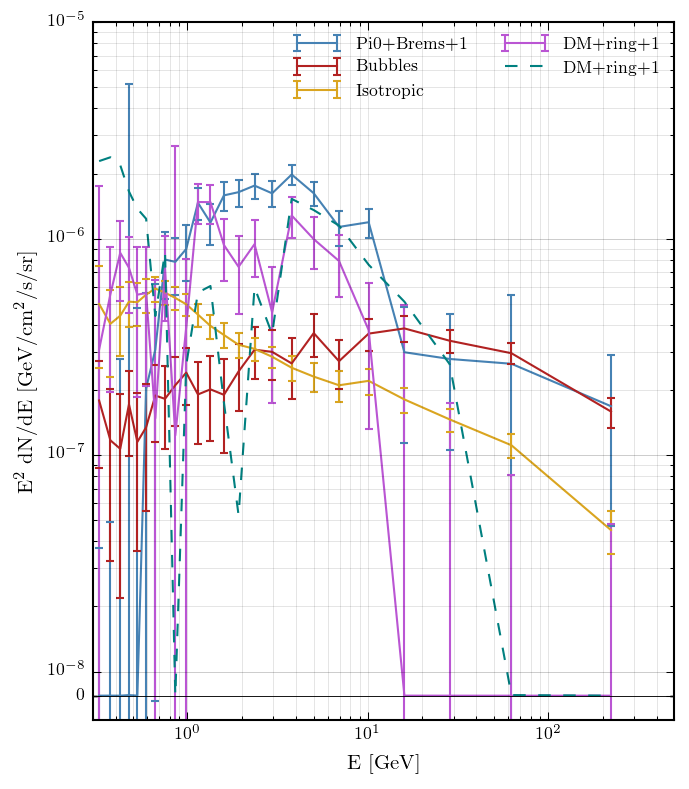

In [20]:
import Template
import Tools, healpy
reload(Tools)


plt.figure(figsize=(5,6))
def PlotComponent(A, name,ls='-'):
    E, flux, stat = A.GetSpectrum(name)
    #if stat
    
    if ls=='-':
        yerr = E**2*stat.T/1e3
    else:
        yerr=None
    
    if name is 'Data':
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=name.replace('_','+'),
                     capthick=1, capsize=2, ls='-',c='k')    
    else:
        plt.errorbar(E/1e3,E**2*flux/1e3, yerr=yerr, label=name.replace('_','+'),capthick=1, capsize=2, ls=ls )
        
        
        
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    plt.grid(which='both', alpha=.1, linestyle='-')
    

PlotComponent(A,'Pi0_Brems_1')
#PlotComponent(A,'ICS')
PlotComponent(A,'Bubbles')
PlotComponent(A,'Isotropic')
PlotComponent(A,'DM_ring_1')
PlotComponent(A2,'DM_ring_1', ls='--')



# print np.sum(A.loglike)
# print np.sum(A2.loglike)

linthresh=1e-8
plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
plt.ylim(-1e-8,1e-5)

plt.legend(frameon=False, fontsize=8,ncol=2, handlelength=3)
#plt.ylim(1e-8,4e-4)
plt.xlim(.3,500)


#A.SaveSpectra('./mod_c/spec_mod_s_42_P8_GC_free_brems.pickle') # 3FGL with ext XCO fitted 
#A.SaveSpectra('./mod_c/spec_mod_s_44_P8_GC_free_brems.pickle') # 3FGL with ext XCO fitted 
#A.SaveSpectra('./mod_c/spec_mod_s_46_P8_GC.pickle') # 3FGL with ext XCO fitted 


In [12]:
import healpy

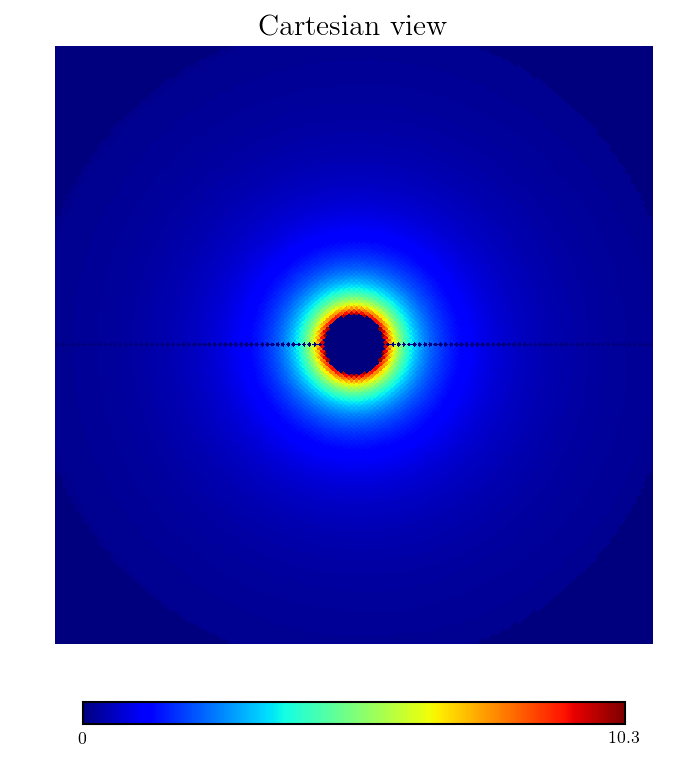

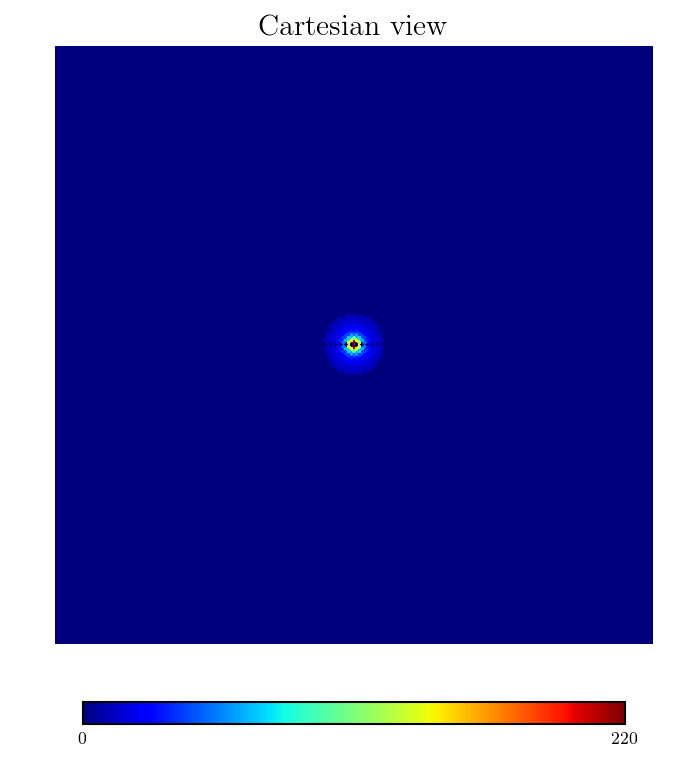

In [17]:
healpy.cartview(A.templateList['DM_ring_1'].healpixCube[10], latra=[-20,20], lonra=[-20,20])
healpy.cartview(A.templateList['DM_ring_0'].healpixCube[10], latra=[-20,20], lonra=[-20,20])